![image](images/111744511_l.jpg)

<center><b><font size="6">NLP Analysis of Boulder area employers reviews</font></b></center>

<span style="color:red; font-size:1.5em">**Phase 4 Final Project**</span><br>
* Student name: <b>Elena Kazakova</b>
* Student pace: <b>full time</b>
* Cohort: <b>DS02222021</b>
* Scheduled project review date: <span style="color:red"><b>06/24/2021</b></span>
* Instructor name: <b>James Irving</b>
* Blog post URL: <span style="color:red"><b>TBD</b></span>

# Table of Contents 

*Click to jump to matching Markdown Header.*<br>

- **[Introduction](#INTRODUCTION)<br>**
- **[Obtain](#Obtain)**<br>
- **[Scrub](#Scrub)**<br>
- **[Explore](#Explore)**<br>
- **[Model](#Model)**<br>
- **[iNterpret](#iNterpret)**<br>
- **[Conclusions/Recommendations](#Conclusions-and-Recommendation)<br>**
___

# Introduction

## Business Problem

Modern days employers want to keep their employees happy and satisfied. The American labor force is steadily becoming more skillful and educated while costs on-job-training and bringing a new employee up to speed are growing. Therefore retaining the best employees with time gains more importance.

**Quote from Survey Monkey site:**<br>

"*Happier employees are more engaged. And engaged employees show increased productivity as well as a far lower rate of absenteeism from work. A healthy work environment matters. A positive work culture encourages employee friendships, improves personal well-being, and ultimately benefits your bottom line.*"


Many companies use surveys as a tool to monitor their employees' satisfaction and concerns. However, they frequently struggle with analyzing answers to open-ended questions in their employees' surveys.
While multiple-choice questions are straight-forward, they only anticipate answers that a surveyor
wrote into the survey with a few predetermined responses. Multiple-choice questions are limited
in a way that allows manipulating data by forcing a survey taker into specific categories of answers.
Open-ended questions allow a person to describe an issue in their own words, highlighting their 
concerns and opinions and providing additional details that otherwise might be missed.<br>
However, open-ended questions provide a challenge for survey processors, especially in a situation 
with a large volume of answers.<p>
The Natural Language Processing approach is a logical approach to that problem. The goals of this project are<br>
    
1. Develop a predictive classification model of employer reviews from INDEED.com job search site.<br>
2. Gain insight into factors affecting satisfaction or dissatisfaction of people with their employer.

# Obtain

## Importing packages and modules

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import re
import seaborn as sns
import inspect
import pickle
import itertools
import joblib
import math
# import lime
# import random
import sys


# from lime import lime_tabular
# from lime import submodular_pick

from sklearn import metrics
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
from nltk import pos_tag
#from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBClassifier
# from xgboost import XGBRFClassifier
from sklearn.dummy import DummyClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


#from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve


from warnings import filterwarnings
filterwarnings('ignore')

np.random.seed(0)
set_config(display='diagram')

## Functions used

In [43]:
def simple_model_validation(model, set_list, title1, title2):
    """A function generating confusion matrices (train/test) with model metrics
    Test set can be either a validation set or a final test set
    *******************
    Arguments:
    model: a model to evaluate
    set_list: a list of datasets names [X_train, X_test, y_train, y_test]
    titel1: a title for the training set confusion matrix
    title2: a title for the test set confusion matrix"""
    
    X_train=set_list[0]
    X_test=set_list[1]
    y_train=set_list[2]
    y_test=set_list[3]
    
    y_pred1 = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    print('***************************************')
    print(model)
    print('***************************************\n')
    
    
    print('Classification Report for training set')
    print('***************************************')
    print(metrics.classification_report(y_train, y_pred1)+'\n')
    print('Classification Report for validation/test set')
    print('***************************************')
    print(metrics.classification_report(y_test, y_pred2)+'\n')
    
    print('***************************************')
    
    categories=['Negative','Neutral','Positive']
    cm1=confusion_matrix(y_train, model.predict(X_train), normalize='true')
    cm2=confusion_matrix(y_test, model.predict(X_test), normalize='true')
    
    fig = plt.figure(figsize=(7,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.set_title(title1)
    ax2.set_title(title2)

    sns.heatmap(cm1, annot=cm1.round(3), fmt="", cmap='Reds', cbar=True,
                xticklabels=categories, yticklabels=categories, ax=ax1)
    sns.heatmap(cm2, annot=cm2.round(3), fmt="", cmap='Reds', cbar=True,
                 xticklabels=categories, yticklabels=categories, ax=ax2)
    plt.tight_layout()
    plt.show()

    return
    
def manual_cleanup(corpus_body_element, dict_replace, sw=stopwords.words('english'),
                   punct_custom=string.punctuation.replace('$',''), print_=True, plot_=True, n=30):
    
    """
    This function itakes in a corpus body element and clean it up in the most simple way:
    1. split it into a list of words
    2. make list elements lower case
    3. remove punctuation (standard minus '$')
    4. remove stopwords
    5. remove numbers
    6. remove empty list elements
    
    It also plots the FreqDist plot of the final list if plot_=True and
    prints original and final word counts if print_=True
    
    ***********************
    Args:
    corpus_body_element: a text element in corpus (review)
    dict_replace: dictionary with new and old values in corpus_body_element to be replaced (like HR or OT)
    sw: stopwords to be used
    punct_custom: customized default string.puctuation characters
    print_: printing flag, default=True
    plot_:  ploting flag, default=True
    n: number of tokens to plot, default=30"""
    
    
    for old, new in dict_replace.items():
        corpus_body_element = corpus_body_element.replace(old, new)

    tokens=corpus_body_element.split(' ')
    corpus_body_element_cleaned = [word.lower() for word in tokens]
    corpus_body_element_cleaned = [s.translate(str.maketrans('', '', punct_custom))\
                  for s in corpus_body_element_cleaned]
    corpus_body_element_cleaned = [token for token in corpus_body_element_cleaned if\
                  token not in sw]
    corpus_body_element_cleaned = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in corpus_body_element_cleaned]
    corpus_body_element_cleaned = [s for s in corpus_body_element_cleaned if s != '']
    
    if print_:
        print(f"The original token list has {len(set(tokens))} words")
        print(f"After the full manual cleanup, the review word list has {len(set(corpus_body_element_cleaned))} unique words")
        
    if plot_:
        fdist = FreqDist(corpus_body_element_cleaned)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    
    return corpus_body_element_cleaned

def changing_target(original_df, column, a=1, b=2, c=3, d=4, e=5, f=0):
    """Streamlining the target classes adjustments"""
    df=original_df.copy()
    df.loc[((df[column] == a) | (df[column] == b)) , column] = '1'
    df.loc[((df[column] == d) | (df[column] == e)) , column] = '3'
    df.loc[((df[column] == c) | (df[column] == f)) , column] = '2'
    return df

def review_tokenize_only(review, tokenizer, dict_replace, stop_words, print_=True, plot_=True, n=30):
    """
    Function tokenizes with RegexpTokenizer,tags with simplified pos-tags plus lemmatizes based on tags.
    ***************
    Args:
    
    review: string to process
    tokenizer: tokenizer to be used
    stop_words: stopwords list, standard or customized
    print_: flag to print the number of unique words after the processing or not, default is True;
    plot_: flag to plot the number of unique words after the processing or not, default is True;
            should be set to False for bulk processing.
    n: a number of words to plot
    """
    for old, new in dict_replace.items():
        review = review.replace(old, new)
        
    re_tokens = tokenizer.tokenize(review)
    re_tokens = [token.lower() for token in re_tokens]
    re_tokens = [token for token in re_tokens if token not in stop_words]
    
    if print_:
        print(f"After using\n\n {tokenizer}\n\n our sample review has {len(set(re_tokens))} unique words")
        
    if plot_:
        fdist = FreqDist(re_tokens)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    return re_tokens

def review_tokenize_lemmatize(review, tokenizer, lemmatizer, dict_replace, stop_words, print_=True, plot_=True, n=30):
    """
    Function tokenizes with RegexpTokenizer,tags with simplified pos-tags plus lemmatizes based on tags.
    ***************
    Args:
    
    review: string to process
    tokenizer: tokenizer to be used
    lemmatizer: lemmatizer to be used
    stop_words: stopwords list, standard or customized
    print_: flag to print the number of unique words after the processing or not, default is True;
    plot_: flag to plot the number of unique words after the processing or not, default is True;
            should be set to False for bulk processing.
    n: a number of words to plot
    """
    re_tokens=review_tokenize_only(review, tokenizer, dict_replace, stop_words, print_=False, plot_=False)
    review_tokens_tagged = pos_tag(re_tokens)
    review_tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in review_tokens_tagged]
    review_tokens_tagged = [lemmatizer.lemmatize(word[0], word[1]) for word in review_tokens_tagged]

    if print_:
        print(f"After using\n\n {tokenizer}\n&\n{lemmatizer}\n\n our sample review has {len(set(review_tokens_tagged))} unique lemmas")
        
    if plot_:
        fdist = FreqDist(review_tokens_tagged)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    return review_tokens_tagged

def get_wordnet_pos(treebank_tag):
    """
    Translate nltk POS to wordnet tags to feed into a lemmatizer. 
    This function is very similar to the one used in the CL lecture. 
    And it is the same function as in stackoverflow
    
    Args
    ***********************
    treebank_tag: a tag from pos_tag processing of a list of words
    
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def adding_to_models_dict(dict_, descr, classifier_name, set_list, model, pickle_file):
    """A function to build a dictionary with all built and evaluated models metrics and information for easy comparison.
    ***************
    Arguments
    dict_: dictionary name
    descr: description of the model ('str')
    classifier_name: the name of the classifier ('str')
    set_list: a list of dataframe names [X_train, X_test, y_train, y_test]
    model: model to add (classifier)
    joblib_file: the name of the file with the saved model ('str')
    """
    X_train=set_list[0]
    X_test=set_list[1]
    y_train=set_list[2]
    y_test=set_list[3]
    
    y_pred1 = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    acc_score_train=round(metrics.accuracy_score(y_pred1, y_train),3)
    acc_score_test=round(metrics.accuracy_score(y_pred2, y_test),3)
    
    f1_score_train=round(metrics.f1_score(y_pred1, y_train, average="macro"),3)
    f1_score_test=round(metrics.f1_score(y_pred2, y_test, average="macro"),3)
    
    dict_['Classifier Name'].append(classifier_name)
    dict_['Description'].append(descr)
    dict_['Training or Val/Test'].append('training')
    dict_['Accuracy'].append(acc_score_train)
    dict_['F1 Score'].append(f1_score_train)
    dict_['Saved model'].append(pickle_file)
    
    dict_['Classifier Name'].append(classifier_name)
    dict_['Description'].append(descr)
    dict_['Training or Val/Test'].append('val/test')
    dict_['Accuracy'].append(acc_score_train)
    dict_['F1 Score'].append(f1_score_test)
    dict_['Saved model'].append(pickle_file)
    
    return dict_

def get_importance_logreg(model, X, top_n=30, figsize=(10,10)):
    """Function returns a dataframe with feature importance values and the corresponding coefficient
    in the regression based lodel.It also plots a bar plot of feature importance.
    **************************
    Arguments:
    model: model
    X: a dataframe with the names of the features
    top_n: a number of features to display on a plot (default is 20)
    figure: a tuple with a figure size (default is (15,15))"""
    
    feature_names = X.columns
    w0 = model.intercept_[0]
    w = model.coef_[0]
    
    pd.set_option('display.width', 1000)
    feature_importance = pd.DataFrame(feature_names, columns = ['Feature'])
    feature_importance['Importance'] = pow(math.e, abs(w))
    feature_importance['Coefficient'] = w
    feature_importance = feature_importance.sort_values(by = ["Importance"], ascending=True).tail(top_n)
 

    ax = feature_importance.plot.barh(x='Feature', y='Importance', figsize=figsize, title='Feature Importance',
                                     ylabel='Feature')
    plt.show()
    return feature_importance

def get_importance_tree(model, X, top_n=30, figsize=(10,10), plot=True):
    """Function returns a dataframe with feature importance values and the corresponding coefficient
    in the decisiontree based model. It also plots a bar plot of feature importance.
    **************************
    Arguments:
    model: model
    X: a dataframe with the names of the features
    top_n: a number of features to display on a plot (default is 20)
    figure: a tuple with a figure size (default is (15,15))"""
    
    df_importance = pd.Series(model.feature_importances_, index=X.columns)
    
    if plot:
        df_importance.sort_values(ascending=True).tail(top_n).plot(kind='barh',
                                                               figsize=figsize, title='Feature Importances',
                                                               ylabel='Feature')
    else:
        df_importance.sort_values(ascending=True).tail(top_n)
        
    return df_importance

def show_random_observation(model1, model2, X1, X2, y, exlainer1,explainer2):
    """This functions displays Lime model explanation for a random observation
    and predicted values from two models.
    **********************
    Arguments
    model1: predictive model #1
    model2: predictive model #2
    X1: test set data with one set of features appropriate for model1
    X2: test set data with one set of features appropriate for model2
    y: test set target (dataframe/series)
    explainer1: lime_tabular.LimeTabularExplainer for model1
    explainer2: lime_tabular.LimeTabularExplainer for model2"""
    
    idx = random.randint(1, X1.shape[0])

    if model1.predict(X1)[idx]==1:
        prediction1='Negative'
    if model1.predict(X1)[idx]==2:
        prediction1='Neutral'
    else:
        prediction1='Positive'
        
    if model2.predict(X2)[idx]==1:
        prediction2='Negative'
    if model2.predict(X2)[idx]==2:
        prediction2='Neutral'
    else:
        prediction2='Positive'

    if y.iloc[idx]=='1':
        actual='Negative'
    if y.iloc[idx]=='2':
        actual='Neutral'
    else:
        actual='Positive'

    print('Prediction from the first model : {}'.format(prediction1))
    print('Prediction from the second model : {}'.format(prediction2))
    print('Actual :   {} '.format(actual))

    exp1 = explainer1.explain_instance(X1.values[idx], model1.predict_proba, num_features=10)
    exp2 = explainer2.explain_instance(X2.values[idx], model2.predict_proba, num_features=10)
    
    exp1.save_to_file('exp1.html')
    exp2.save_to_file('exp2.html')
    exp1.show_in_notebook()
    exp1.as_pyplot_figure();
    exp2.show_in_notebook()
    exp2.as_pyplot_figure();

def spot_check(df,  retries = 5, errorMessage = 'At least one character must be used'):
    """The function takes in up to 5 words as input values and calculates their ratio usage in
    positive, negative and neutral reviews in the dataframe with the reviews.
    Argument:
    df: dataframe with reviews and "Rating" & "Review_Text columns"
    """
    while retries > 0:
        value = input("Enter a word to check: ")
        word=value.strip()
        if word:
            negative_reviews = df[df['Rating']=='1']
            positive_reviews = df[df['Rating']=='3']
            neutral_reviews = df[df['Rating']=='2']

            contain_values1 = df[(df['Review_Text'].str.contains(word)) & (df['Rating']=='1')]
            contain_values2 = df[(df['Review_Text'].str.contains(word)) & (df['Rating']=='2')]
            contain_values3 = df[(df['Review_Text'].str.contains(word)) & (df['Rating']=='3')]
                                                                                                         
            ratio_negative_time=len(contain_values1)/len(negative_reviews)
            ratio_positive_time=len(contain_values3)/len(positive_reviews)
            ratio_neutral_time=len(contain_values2)/len(neutral_reviews)
                                                                 
            print('Ratio of negative reviews with the word "{}":{}\nRation of positive reviews with the word "{}":{}\nRation of neutral reviews with the word "{}":{}\n'.
                  format(word, round(ratio_negative_time,3),word,
                         round(ratio_positive_time,3),word,
                         round(ratio_neutral_time,3)))
                                                                 
            retries -= 1
            continue
        else:
            print(errorMessage)
            retries -= 1

def pull_out_sentences(df, n=1, m=3):
    """The function takes in a datafame of reviews and the number of reviews
    in a category (Negative/Neutral/Positiveewtral, input variable. It also count all reviews in the category
    with a word or a bigram
    )
    Argument:
    df: dataframe with reviews and "Rating" & "Review_Text columns"
    n: number of retries, default=3
    """
    retries=n
    while retries > 0:
        class_=input("Enter a review class to check (Negative/Positive/Neutral): ")
        if class_=='Negative':
            df_ = df[df['Rating']=='1']
        elif class_=='Positive':
            df_ = df[df['Rating']=='3']
        elif class_=='Neutral':
            df_ = df[df['Rating']=='2']
        else:
            print('There is no such class')
        
        value = input("Enter a word/a bigram to check: ")
        word=value.strip()
                           
        if word:
            display_df=None
            contain_values_df = df_[(df_['Review_Text'].str.contains(word))]
            print('Class {} contains {} records with word {}'.format(class_,len(contain_values_df),word))
            display_df=contain_values_df.sample(n=m)
            display_df
            
            retries -= 1
            continue

        else:
            print('At least one character must be entered')
            retries -= 1

    return display_df

## Data Description

The data for this project has been obtained by scraping [INDEED job search site]( (https://www.indeed.com/companies/search?q=&l=80301&from=discovery-cmp). The notebook with scraping code is available [here](scraping_indeed.ipynb).<br>
The search was limited to the 50 most popular companies in Boulder, CO area.
INDEED limits the number of companies returned by a query (50). Some of these companies do not have any reviews; therefore, the final list of employers is:<br>
1.	Ball Aerospace
2.	University of Colorado Boulder
3.	Boulder Valley School District
4.	Boulder Community Health
5.	Boulder County CO
6.	Splunk
7.	Naropa University
8.	Amazon
9.	Brookdale Senior Living
10.	IBM
11.	NETA
12.	Apple
13.	City of Boulder CO
14.	Medtronic
15.	Emerson
16.	NetApp
17.	Zayo Group
18.	Whole Foods Market
19.	Particle Measuring Systems
20.	Boulder Medical Center
21.	Sage Hospitality
22.	University of Colorado
23.	Mental Health Partners
24.	Agilent Technologies
25.	Frasier Meadows
26.	Cozymeal
27.	IHS Markit
28.	National Renewable Energy Laboratory
29.	University Corporation for Atmospheric Research
30.	Sprouts Farmers Market
31.	KPMG
32.	New Relic
33.	Excelitas Technologies
34.	Northrop Grumman
35.	KBI Biopharma
36.	Ricoh
37.	Embassy Suites by Hilton
38.	U.S. Department of Commerce
39.	InVitae
40.	Pfizer
41.	SUEZ
42.	PetSmart
43.	Craft Health
44.	Imagine!
45.	King Soopers
46.	Safeway<br><br>

Almost 44% of the reviews belong to Amazon's former and current employees.

Reviews of the companies are from all US states where the companies have operations. The decision not to limit reviews to the Boulder area was made because the number of reviews from the limited geographic area is small and would affect a predictive ability of statistical models.
The original dataset has 12620 records with four columns:
<br><br>
    1.Company name<br>
    2.Unique review identifier<br>
    3.Rating (on the scale between 1 and 5)<br>
    4.Review text<br>
    
The original Rating scale has been changed to the 1-3 range to simplify the analysis. 1 corresponds to Negative reviews, 2-to Neutral reviews, and 3-to Positive reviews. Reviews with the original ratings 1 and 2 were lumped into the Negative category, reviews with the original rating 3 became the Neutral review category, and reviews with the original rating 4 and 5 were combined into a Positive review category.<br><br>
The names of the companies were removed from the text of the reviews to make analysis non-company specific

## Importing data

### Importing original scraped data

[The link to the code in scraping notebook (scraping notebook ](scraping_indeed.ipynb)

In [4]:
# All csv files from multiple scraps

df1=pd.read_csv('data/scrap_results1.csv')
df2=pd.read_csv('data/scrap_results2.csv')
df3=pd.read_csv('data/scrap_results3.csv')
df4=pd.read_csv('data/scrap_results4.csv')
df5=pd.read_csv('data/scrap_results5.csv')
df6=pd.read_csv('data/scrap_results6.csv')
df7=pd.read_csv('data/scrap_results7.csv')
df8=pd.read_csv('data/scrap_results8.csv')
df9=pd.read_csv('data/scrap_results9.csv')
df10=pd.read_csv('data/scrap_results10.csv')
df=pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [5]:
df.head()

,Company,ReviewID,Rating,Review_Text
0,Ball Aerospace,1f4e4k5dk2v72000,4.0,I worked as a contractor for them for about tw...
1,Ball Aerospace,1f76ir3183obs000,1.0,"Worst place I've ever worked, hands down."
2,Ball Aerospace,1f5rn12k9u3af800,3.0,The compnay has good benefits and even a small...
3,Ball Aerospace,1f5e5q2f1u2n1800,1.0,Company has no life and work balance. Everyda...
4,Ball Aerospace,1f3b4lrdou3bc800,5.0,"I no long work for Ball, the drive to work was..."


In [6]:
df.Rating.value_counts()

5.0    37147
4.0    33875
3.0    26850
1.0    12285
2.0    11463
Name: Rating, dtype: int64

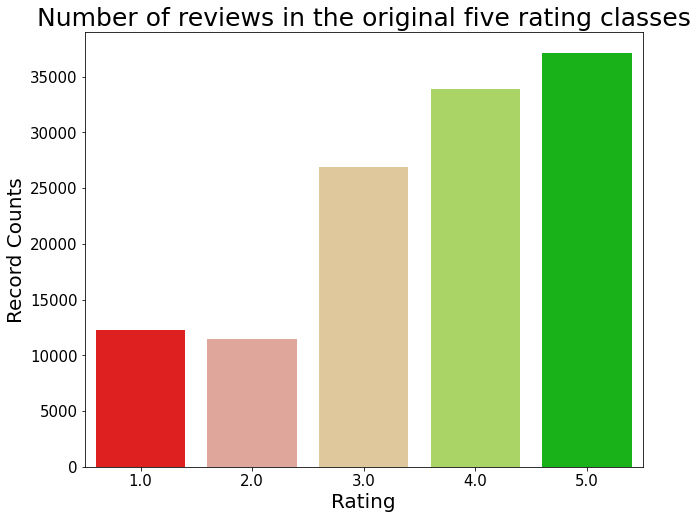

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='Rating', data=df, palette=['#ff0000','#EA9F90','#EACC90', '#AEE653', '#00cc00'], ax=ax)
ax.set_title('Number of reviews in the original five rating classes', fontsize=25);
ax.set_ylabel('Record Counts', fontsize=20);
ax.set_xlabel('Rating', fontsize=20);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.tick_params(labelsize=15)


In [26]:
# Changing the original Rating scale from 1-5 to 1-3

df=changing_target(df, 'Rating')

In [27]:
df.head()

,Company,ReviewID,Rating,Review_Text
0,Ball Aerospace,1f4e4k5dk2v72000,3,I worked as a contractor for them for about tw...
1,Ball Aerospace,1f76ir3183obs000,1,"Worst place I've ever worked, hands down."
2,Ball Aerospace,1f5rn12k9u3af800,2,The compnay has good benefits and even a small...
3,Ball Aerospace,1f5e5q2f1u2n1800,1,Company has no life and work balance. Everyda...
4,Ball Aerospace,1f3b4lrdou3bc800,3,"I no long work for Ball, the drive to work was..."


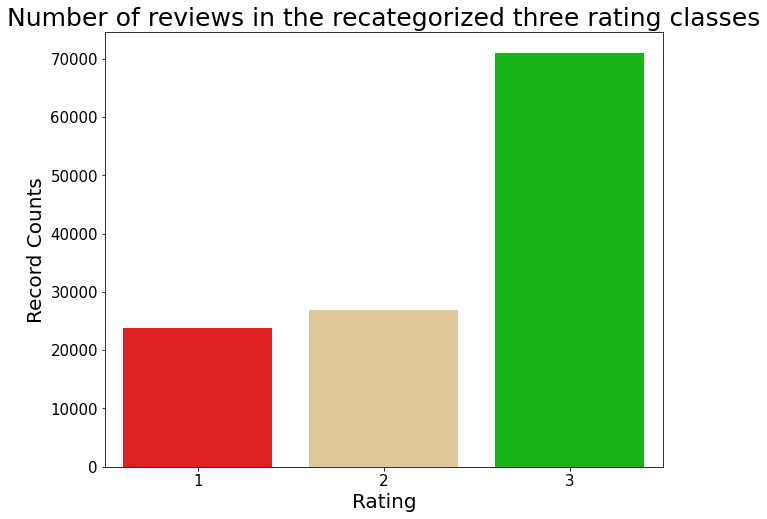

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='Rating', data=df, palette=['#ff0000','#EACC90', '#00cc00'], order=['1','2','3'],ax=ax)
ax.set_title('Number of reviews in the recategorized three rating classes', fontsize=25);
ax.set_ylabel('Record Counts', fontsize=20);
ax.set_xlabel('Rating', fontsize=20);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.tick_params(labelsize=15)

## Keeping all frequently variables together

#### Eliminating company names from the word pool

In [8]:
list_companies=list(df['Company'].unique())
list_companies

['Ball Aerospace',
 'University of Colorado Boulder',
 'Boulder Valley School District',
 'Boulder Community Health',
 'Boulder County, CO',
 'Splunk',
 'Naropa University',
 'Amazon.com',
 'Brookdale Senior Living',
 'IBM',
 'NETA',
 'Apple',
 'City of Boulder, CO',
 'Medtronic',
 'Emerson',
 'NetApp',
 'Zayo Group',
 'Whole Foods Market',
 'Particle Measuring Systems',
 'Boulder Medical Center',
 'Sage Hospitality',
 'University of Colorado',
 'Mental Health Partners',
 'Agilent Technologies',
 'Frasier Meadows',
 'Cozymeal',
 'IHS Markit',
 'National Renewable Energy Laboratory',
 'University Corporation for Atmospheric Research',
 'Sprouts Farmers Market',
 'KPMG',
 'New Relic',
 'Excelitas Technologies',
 'Northrop Grumman',
 'KBI Biopharma',
 'Ricoh',
 'Embassy Suites by Hilton',
 'U.S. Department of Commerce',
 'InVitae',
 'Pfizer',
 'SUEZ',
 'PetSmart',
 'Craft Health',
 'Imagine!',
 'King Soopers',
 'Safeway']

In [9]:
# Replacing some words in the comanies names with '' to avoid including them into companies_names stopwords

dict_replace2={' Center':'',' Technologies':'',' of Colorado':'',' Commerce':'','Medical':'','Particle':'',
              'Community':'',' Health':'','Suites':'',' Market':'',' Systems':'','Senior':'','Living':'',
              'Department':'','School ':'','Research':'','New':'','Group':'',' Measuring':'',' District':'',
              ' Energy':'','University ':'','Hospitality':'','National ':'','Mental':'',' Partners':''}

list_companies_tokens=[]
for element in list_companies:
    token=manual_cleanup(element, dict_replace2, print_=False, plot_=False, n=30)
    list_companies_tokens.append(token)
    
#list_companies_tokens

flat_list_companies_tokens = [item for sublist in list_companies_tokens for item in sublist]
flat_list_companies_tokens=list(set(flat_list_companies_tokens))
companies_sw=flat_list_companies_tokens

#### Variables

In [10]:
# Keeping all variables use frequently together
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
sw=stopwords.words('english')
sw2=stopwords.words('english')+companies_sw+['work']
dict_replace={' OT ': ' overtime ', ' HR ':' human resources ' }
punct_custom=string.punctuation.replace('$','')

In [11]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


# Scrub and Explore

## Exploratory Data Analysis

### Distribution of Reviews

<AxesSubplot:>

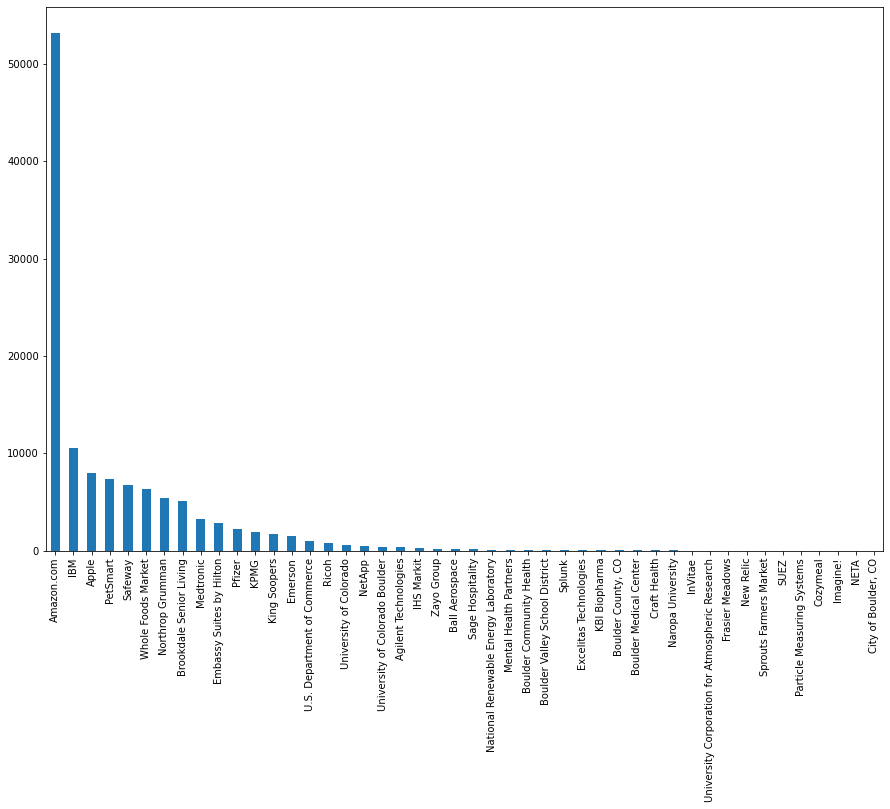

In [12]:
df['Company'].value_counts().plot(kind='bar', figsize=(15,10))

> The plot shows how overwhelmingly present  Amazon reviews are in the dataset. In fact, Amazon reviews represent 44% of the total number of reviews.

In [13]:
df_other=df.loc[df['Company']!='Amazon.com']
df_other.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68435 entries, 0 to 176255
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      68435 non-null  object
 1   ReviewID     68435 non-null  object
 2   Rating       68435 non-null  object
 3   Review_Text  68435 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [14]:
df_amazon=df.loc[df['Company']=='Amazon.com']
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53185 entries, 810 to 102496
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      53185 non-null  object
 1   ReviewID     53185 non-null  object
 2   Rating       53185 non-null  object
 3   Review_Text  53185 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


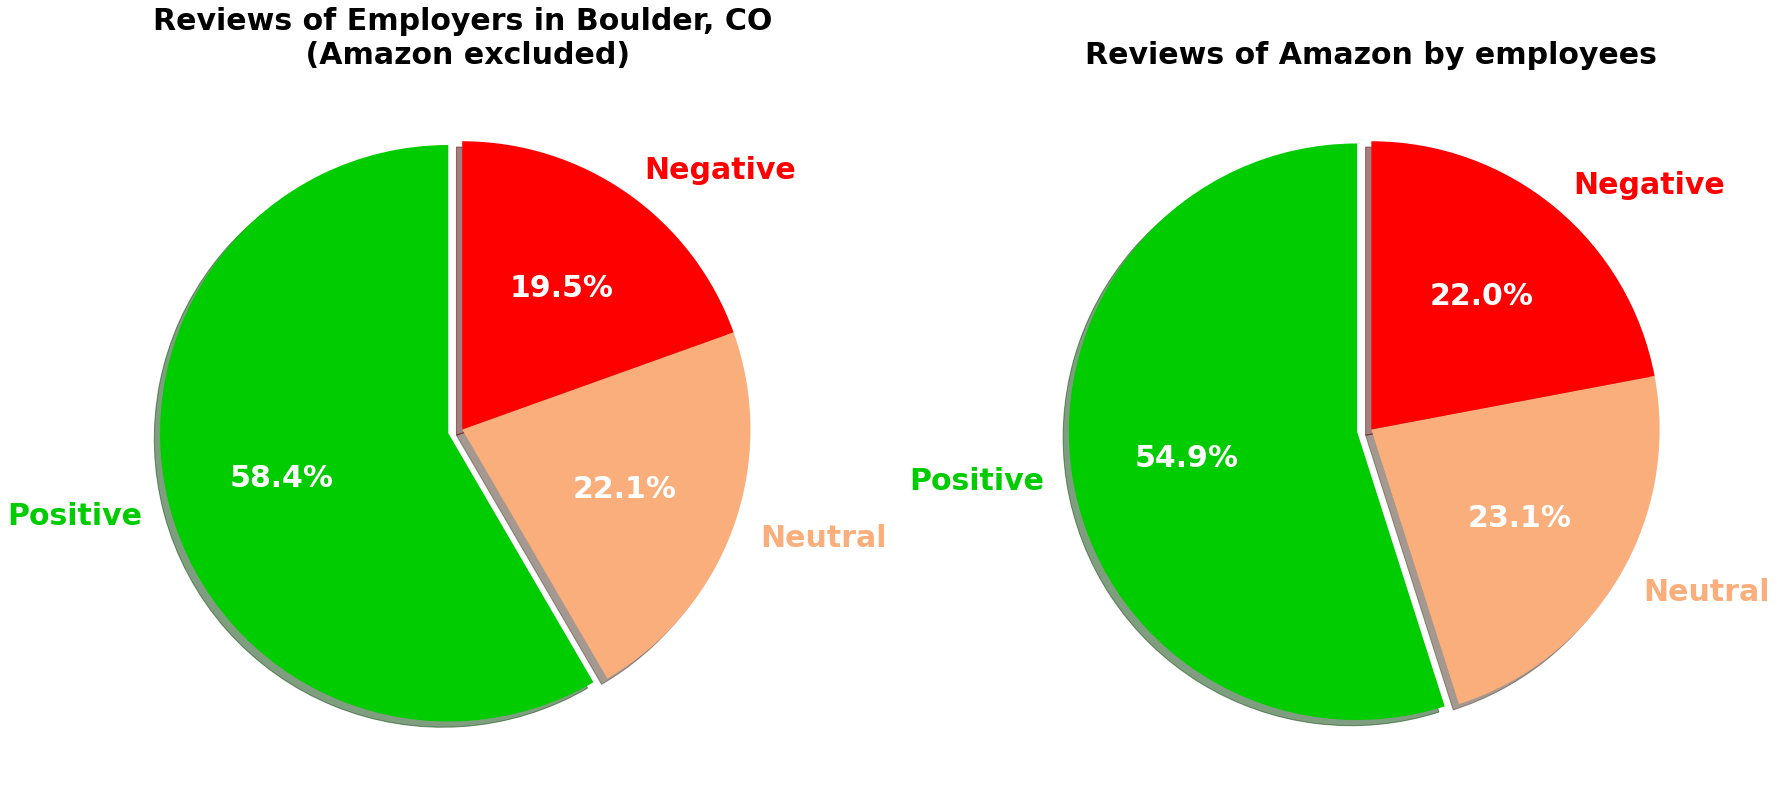

In [15]:
# Pie plot of Rating values for the full dataset and Amazon dataset separately

labels = ['Positive', 'Neutral','Negative']
colors = ['#00cc00','#FAAE7B', '#ff0000']
explode = [0.05, 0, 0]

fig, axes = plt.subplots(figsize=(25,45), ncols=2)

patches1, texts1, pcts1 = axes[0].pie(df.Rating.value_counts(), labels = labels, explode = explode, colors=colors, shadow = True,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 30,'color':'white','weight':'bold'})
for i, patch in enumerate(patches1):
    texts1[i].set_color(patch.get_facecolor())    
plt.setp(pcts1, color='white')
plt.setp(texts1, fontweight=800)
axes[0].set_title('Reviews of Employers in Boulder, CO\n (Amazon excluded)', fontsize=30, weight='bold');



patches2, texts2, pcts2 = axes[1].pie(df_amazon.Rating.value_counts(), labels = labels, explode = explode, colors=colors, shadow = True,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 30,'color':'white','weight':'bold'})
for i, patch in enumerate(patches2):
    texts2[i].set_color(patch.get_facecolor())    
plt.setp(pcts2, color='white')
plt.setp(texts2, fontweight=800)


axes[1].set_title('Reviews of Amazon by employees', fontsize=30, weight='bold');

plt.tight_layout()

plt.show() 

> The plot above shows that the percentage of positive reviews of Amazon is 3.5% lower than in all other employer reviews. It is not a very significant difference, but it's worth noting.

In [16]:
# plt.figure(figsize = (15,8))
# ax=sns.countplot(x='Company', data=df, order=df.Company.value_counts().index)
df_other=df.loc[df['Company']!='Amazon.com']
df_bigboys=df_other.loc[df_other['Company'].isin(['IBM','Apple','PetSmart','Safeway',
                                                  'Whole Foods Market','Northrop Grumman','Brookdale Senior Living',
                                                 'Pfizer','KPMG','King Soopers','Medtronic', 'Emerson',
                                                  'Embassy Suites by Hilton','Ricoh','NetApp','Agilent Technologies',
                                                 'University of Colorado','University of Colorado Boulder',
                                                 'U.S. Department of Commerce'])]



df_littleboys=df_other.loc[~df_other['Company'].isin(['IBM','Apple','PetSmart','Safeway',
                                                  'Whole Foods Market','Northrop Grumman','Brookdale Senior Living',
                                                 'Pfizer','KPMG','King Soopers','Medtronic', 'Emerson',
                                                  'Embassy Suites by Hilton','Ricoh','NetApp','Agilent Technologies',
                                                 'University of Colorado','University of Colorado Boulder',
                                                 'U.S. Department of Commerce'])]

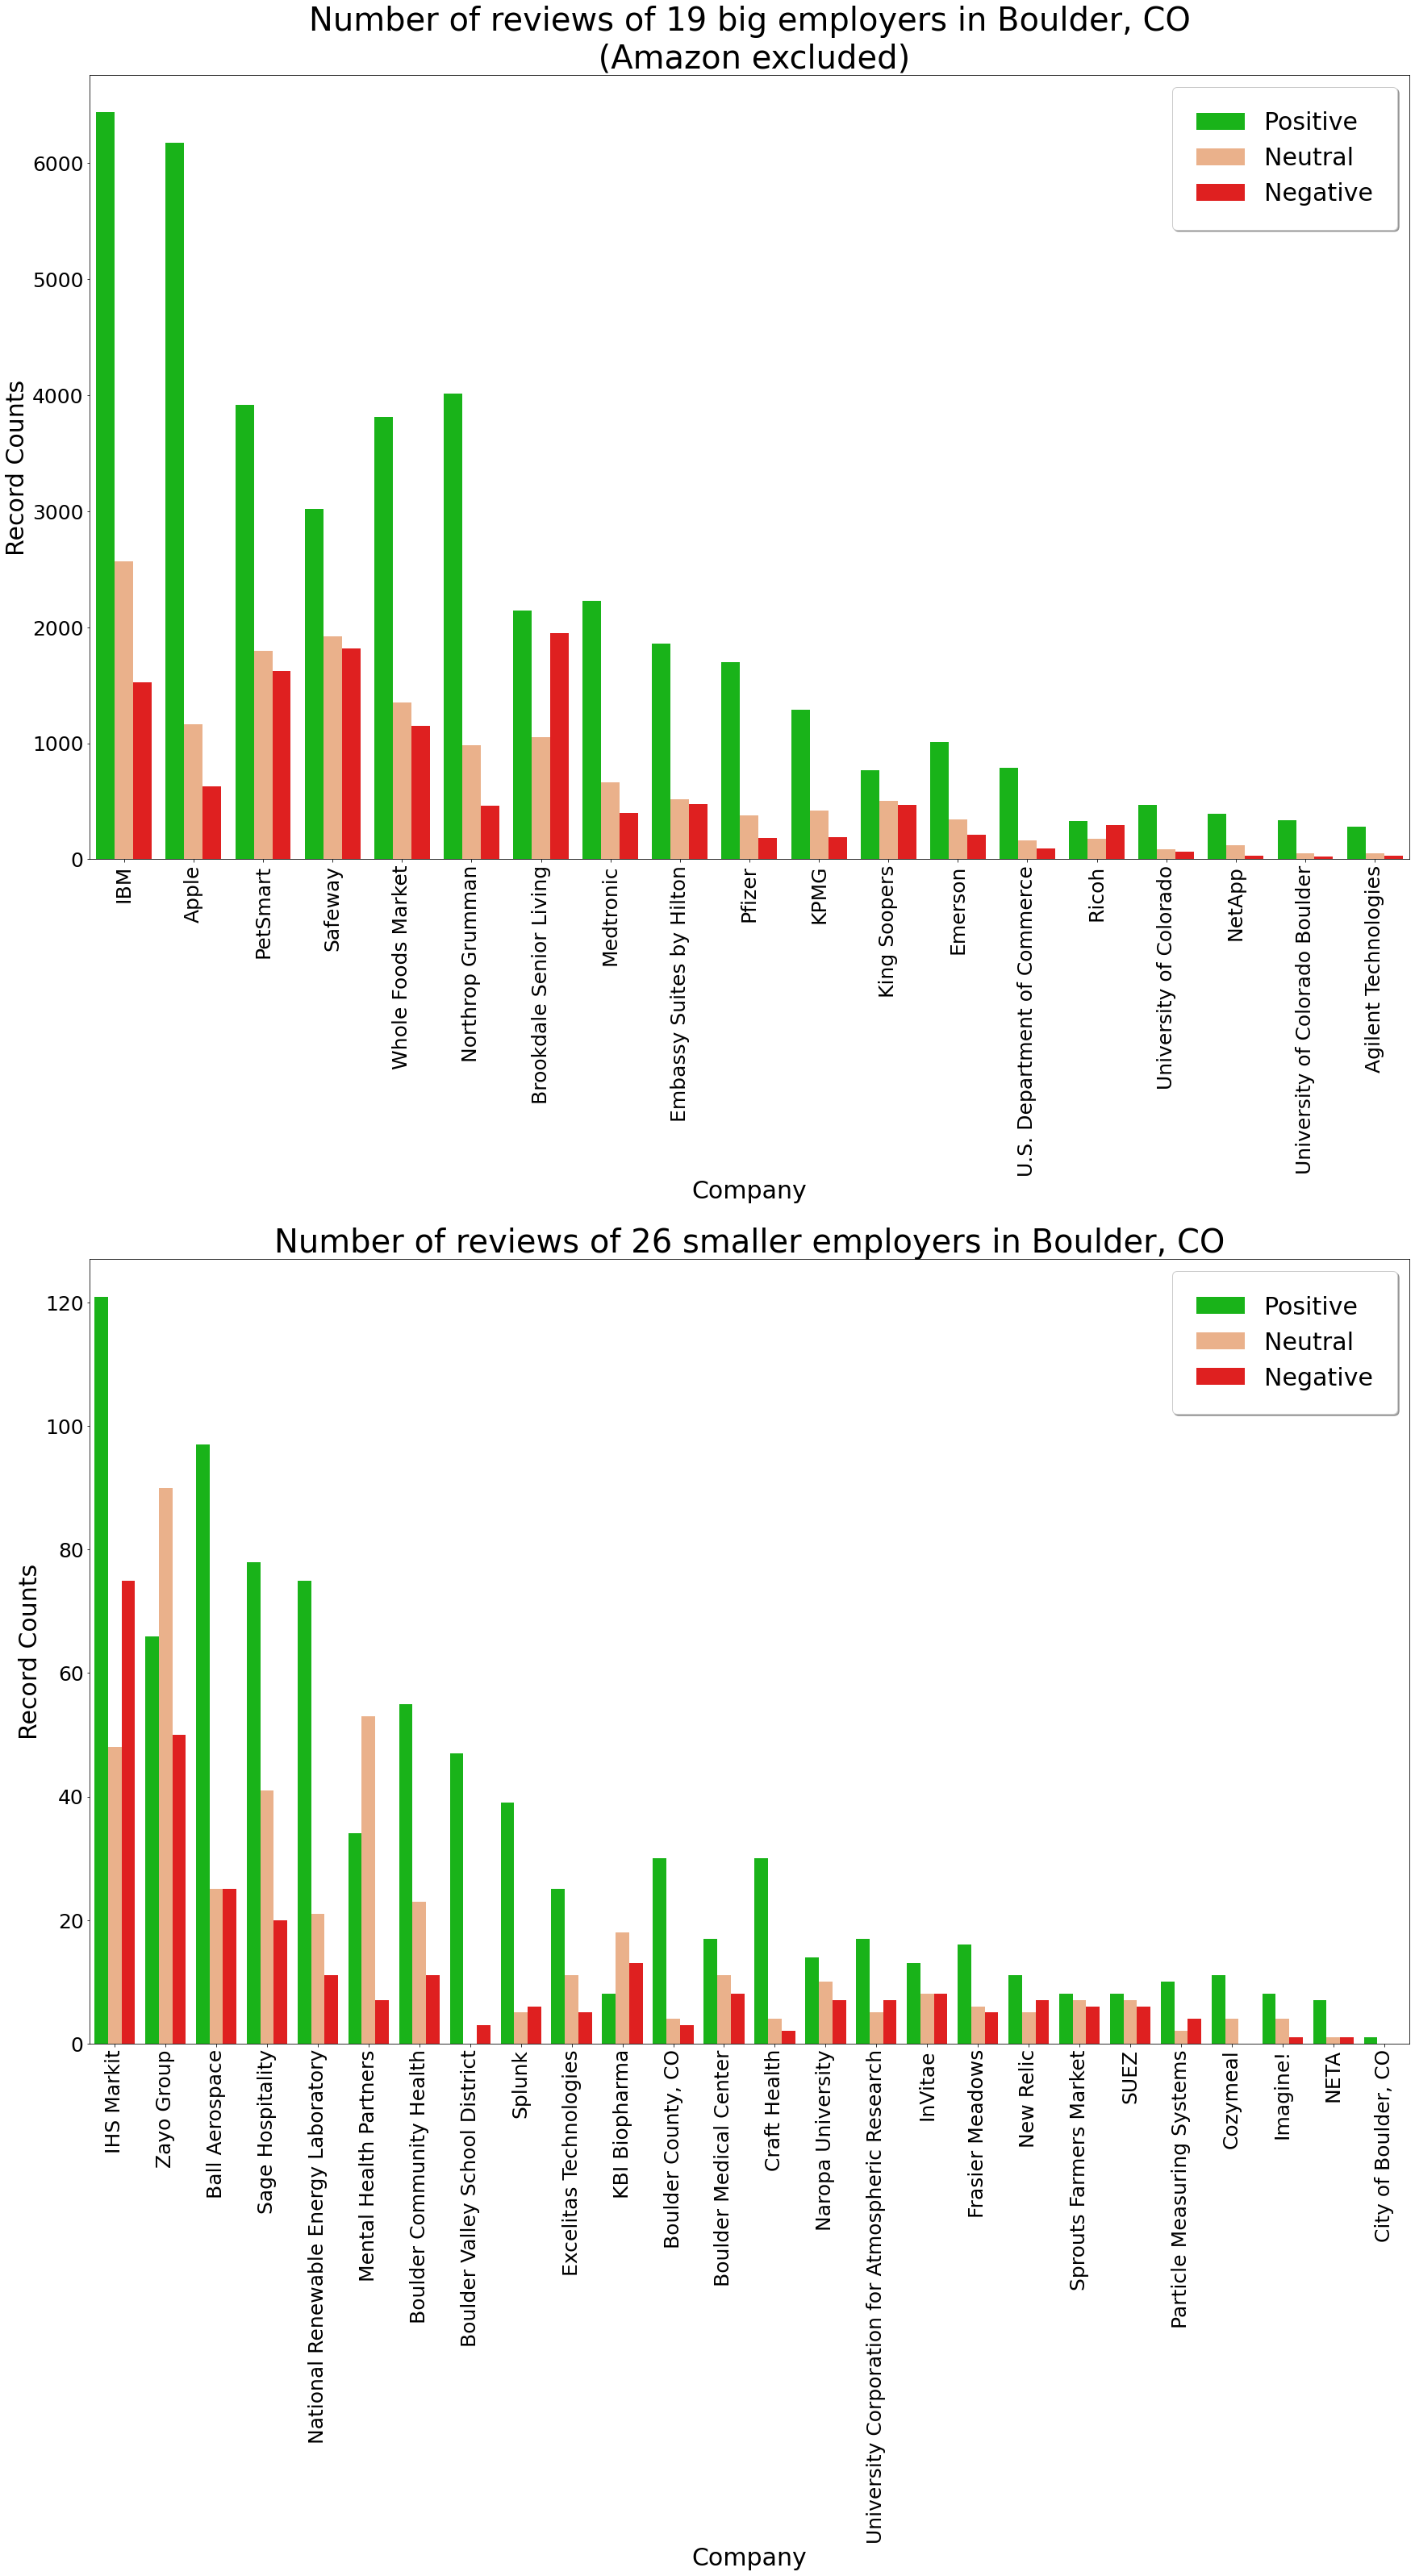

In [17]:
fig, axes = plt.subplots(figsize=(25,45), nrows=2)

sns.countplot(x='Company', data=df_bigboys, hue='Rating', palette=['#00cc00','#FAAE7B', '#ff0000'],
              order=df_bigboys.Company.value_counts().index, ax=axes[0])
sns.countplot(x='Company', data=df_littleboys, hue='Rating', palette=['#00cc00','#FAAE7B', '#ff0000'],
              order=df_littleboys.Company.value_counts().index, ax=axes[1])


axes[0].set_title('Number of reviews of 19 big employers in Boulder, CO\n (Amazon excluded)', fontsize=40);
axes[0].set_ylabel('Record Counts', fontsize=30);
axes[0].set_xlabel('Company', fontsize=30);
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=25)
axes[0].tick_params(labelsize=25)
axes[0].legend(['Positive', 'Neutral','Negative'], fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=30,
              loc='upper right')

axes[1].set_title('Number of reviews of 26 smaller employers in Boulder, CO', fontsize=40);
axes[1].set_ylabel('Record Counts', fontsize=30)
axes[1].set_xlabel('Company', fontsize=30);
axes[1].tick_params(labelsize=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=25)
axes[1].legend(['Positive', 'Neutral','Negative'], fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=30,
              loc='upper right')

plt.tight_layout(pad=3)
sns.set_context("talk");

> The plot above shows that most employers in the area have more positive reviews than negative ones, with a few outliers mostly among small employers with very few reviews (less than 50).

### Exploring corpus (body and target)

In [18]:
corpus=df.drop(['Company','ReviewID'], axis=1).copy()
corpus=corpus.rename(columns={'Rating': 'target', 'Review_Text': 'body'})
corpus.reset_index(drop=True, inplace=True)
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [19]:
corpus.shape

(121620, 2)

In [20]:
corpus.head()

,target,body
0,3,I worked as a contractor for them for about tw...
1,1,"Worst place I've ever worked, hands down."
2,2,The compnay has good benefits and even a small...
3,1,Company has no life and work balance. Everyda...
4,3,"I no long work for Ball, the drive to work was..."


In [21]:
corpus.target.value_counts()

3    71022
2    26850
1    23748
Name: target, dtype: int64

In [22]:
print(len(corpus))

121620


### Venn diagrams

In [23]:
# Priliminary tokenization for EDA (custom tokenizer)

> It's a dataframe with tokenized reviews in the 'tokens' column. Filling it in took about 17.5 minutes, so I saved the result to 'eda_pickle.pkl' to use in the EDA process.

In [24]:
# dict_replace={' OT ': ' overtime ', ' HR ':' human resources '}

# df_venn=corpus.copy()
# df_venn['tokens'] = ''

# for i in range(0,len(df_venn)):
#     df_venn.tokens[i]=manual_cleanup(df_venn.body[i], dict_replace, print_=False, plot_=False)

# df_venn.to_pickle('pickles/eda_pickle.pkl')

In [25]:
df_eda=pd.read_pickle('pickles/eda_pickle.pkl')
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
 2   tokens  121620 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [26]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
 2   tokens  121620 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [27]:
df_rating_negative=df_eda.loc[df_eda.target=='1']
df_rating_neutral=df_eda.loc[df_eda.target=='2']
df_rating_positive=df_eda.loc[df_eda.target=='3']
print(len(df_rating_negative), len(df_rating_neutral), len(df_rating_positive))

23748 26850 71022


In [28]:
df_rating_negative.head()

,target,body,tokens
1,1,"Worst place I've ever worked, hands down.","[worst, place, ive, ever, worked, hands]"
3,1,Company has no life and work balance. Everyda...,"[company, life, work, balance, everyday, full,..."
5,1,I’ve watched Ball morph into a management stra...,"[i’ve, watched, ball, morph, management, strat..."
7,1,The management at this company is clueless as ...,"[management, company, clueless, high, work, lo..."
8,1,Ball has an old reputation of being a great co...,"[ball, old, reputation, great, company, reputa..."


In [29]:
negative_words=list(df_rating_negative.tokens)
flat_list_negative_words = []
for sublist in negative_words:
    for item in sublist:
        flat_list_negative_words.append(item)
set_negative_words=set(flat_list_negative_words)
len(set_negative_words)

25887

In [30]:
flat_list_negative_words[:10]

['worst',
 'place',
 'ive',
 'ever',
 'worked',
 'hands',
 'company',
 'life',
 'work',
 'balance']

In [31]:
positive_words=list(df_rating_positive.tokens)
flat_list_positive_words = []
for sublist in positive_words:
    for item in sublist:
        flat_list_positive_words.append(item)
set_positive_words=set(flat_list_positive_words)
len(set_positive_words)

38091

In [32]:
neutral_words=list(df_rating_neutral.tokens)
flat_list_neutral_words = []
for sublist in neutral_words:
    for item in sublist:
        flat_list_neutral_words.append(item)
set_neutral_words=set(flat_list_neutral_words)
len(set_neutral_words)

23070

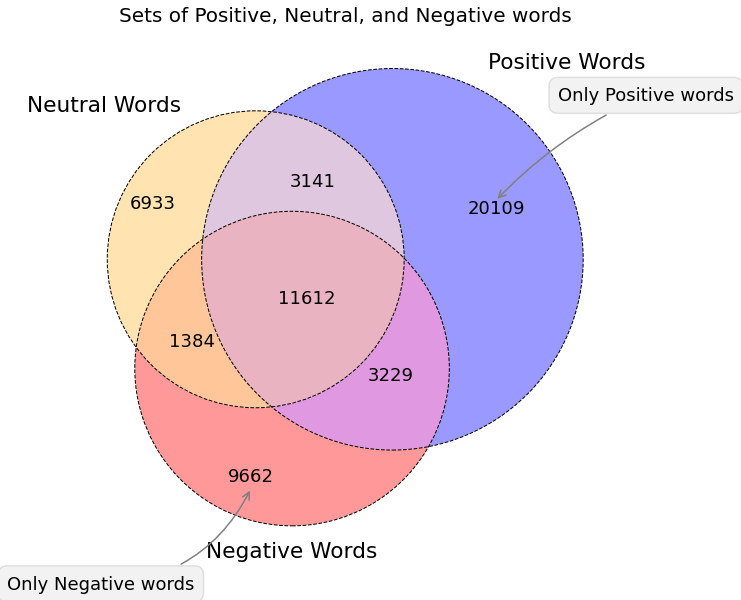

In [33]:

plt.figure(figsize=(10, 10))
ax=plt.gca()


sets=[set_neutral_words, set_positive_words, set_negative_words]
labels=('Neutral Words', 'Positive Words', 'Negative Words')

v=venn3(subsets=sets, set_labels = labels, ax=ax, set_colors=("orange", "blue", "red"))

v.get_patch_by_id('100').set_alpha(0.3)


venn3_circles(subsets=sets,
              linestyle="dashed", linewidth=1)

plt.annotate('Only Positive words',
             xy=v.get_label_by_id('010').get_position() - np.array([0, -0.02]), xytext=(150,100),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round, pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',color='gray'))

plt.annotate('Only Negative words',
             xy=v.get_label_by_id('001').get_position() - np.array([0, 0.03]), xytext=(-150,-100),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round, pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray'))


plt.title('Sets of Positive, Neutral, and Negative words', fontsize='20')
plt.show()

> The Venn diagram shows a significant overlap between Negative, Positive, and Neutral word subsets. Given the numbers, it is fair to expect that Positive reviews will be most easily identifiable, while Neutral reviews will be most challenging to identify.

### Word Clouds

In [34]:
text_positive=' '.join(flat_list_positive_words)
text_negative=' '.join(flat_list_negative_words)
text_neutral=' '.join(flat_list_neutral_words)
stopwords_cloud=set(sw)
stopwords_cloud.update(['work', 'job', 'amazon', 'company','good','great','place','also','really',
                        'overall','would','get','lot', 'enjoyed','enjoy','love','however','make',
                        'loved','even','done','still','like','come','well','though','give', 'u',
                         'go','thing','really','one','take','want','make','could','say'])
cloud_kws=dict(stopwords=stopwords_cloud, width=1200, height=800, min_font_size=10, max_words=30,
               collocation_threshold = 5)

# Create a dictionary to generate all three clouds
wordcloud_dict={}
wordcloud_dict['Negative']= WordCloud(**cloud_kws,colormap='Reds', random_state=123).generate(text_negative)
wordcloud_dict['Positive']= WordCloud(**cloud_kws,colormap='Greens', random_state=123).generate(text_positive)
wordcloud_dict['Neutral']= WordCloud(**cloud_kws,colormap='Greys', random_state=123).generate(text_neutral)
wordcloud_dict

{'Negative': <wordcloud.wordcloud.WordCloud at 0x24b75ba5b80>,
 'Positive': <wordcloud.wordcloud.WordCloud at 0x24b796bc370>,
 'Neutral': <wordcloud.wordcloud.WordCloud at 0x24b796af9a0>}

In [35]:
text_neutral[:20]

'compnay good benefit'

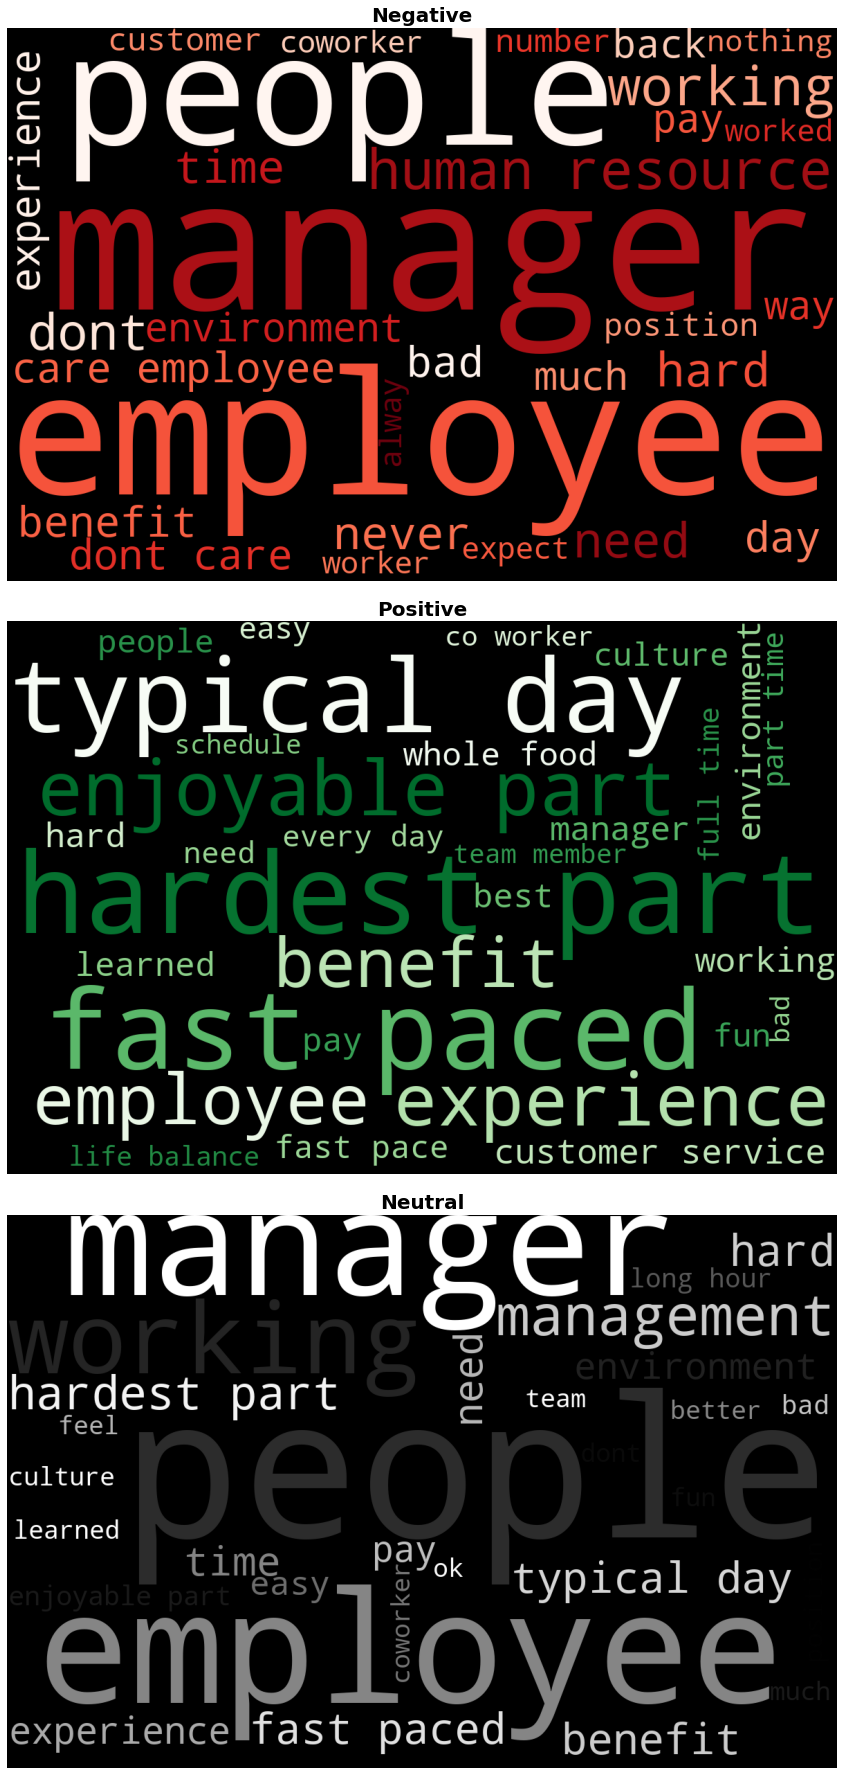

In [36]:
# wordcloud = WordCloud(stopwords=stopwords_cloud_p,max_font_size=100, max_words=30, 
#                       collocation_threshold = 5,background_color="white").generate(text_negative)

# Display the generated images:

fig, ax=plt.subplots(nrows=3, figsize=(15,25))
title_font={'fontweight':'bold','fontsize':20}

i=0
for rating, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(rating, fontdict=title_font)
    ax[i].axis('off')
    i+=1

plt.tight_layout()
plt.show()

In [37]:
# Exploring results of the wordclouds

df_negative=df_eda.loc[df_eda.target=='1']
df_neutral=df_eda.loc[df_eda.target=='2']
df_positive=df_eda.loc[df_eda.target=='3']
df_negative=df_negative.reset_index(drop=True)
df_neutral=df_neutral.reset_index(drop=True)
df_positive=df_positive.reset_index(drop=True)

df_temp=df_positive[df_positive['body'].str.contains('hardest part')]
df_temp=df_temp.reset_index(drop=True)

In [38]:
df_temp.body[10]

'I work at a day treatment school with BVSD, my typical day at work is always changing depending on the students. I learned how to handle different students with different mental capabilities. The hardest part of my job is sometimes having to put hands-on on another student, whether it is to protect them from other or themselves. The most enjoyable part of the job is having our students transition to a mainstream school. The management I work closely with is amazing. They always have time to check in with me and they give great constructive criticism.'

> The workclouds are just visualization tools and do not represent the importance of the words for statistical models. However, they signify the frequency of the words used in a particular context. In this case, it's the frequency of the words used in negative, positive, and neutral reviews. The wordclouds above show that the most frequent words used in the negative and neutral reviews are 'employee' and 'manager,' while in positive reviews, words are more diverse. I will perform a similar assessment after the modeling part.

### Word distributions

In [39]:
flat_list_negative_words[:10]

['worst',
 'place',
 'ive',
 'ever',
 'worked',
 'hands',
 'company',
 'life',
 'work',
 'balance']

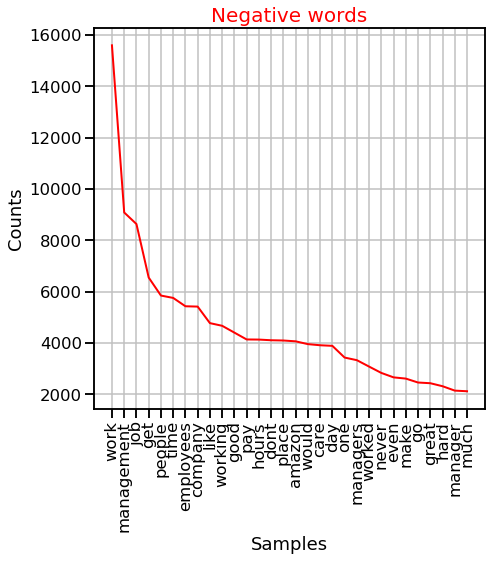

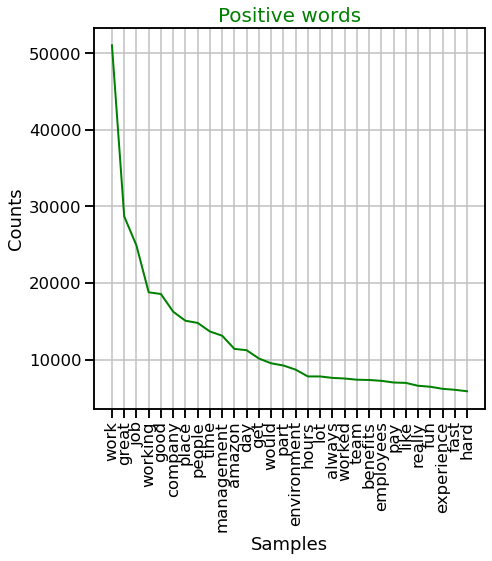

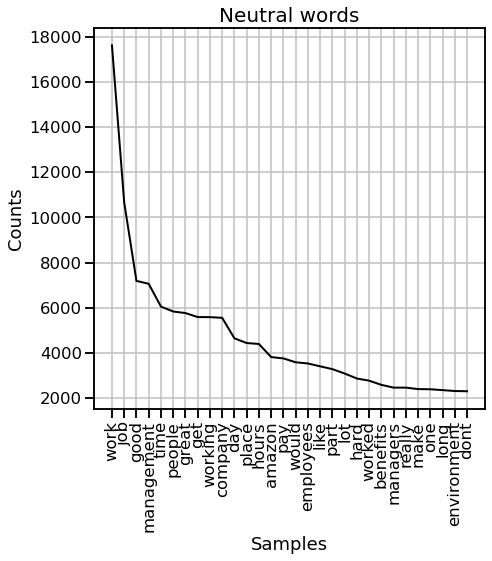

<AxesSubplot:title={'center':'Neutral words'}, xlabel='Samples', ylabel='Counts'>

In [40]:
fdist=FreqDist(flat_list_negative_words)
plt.figure(figsize=(7, 7))
plt.title('Negative words', fontsize=20, c='red')
fdist.plot(30, color='red')


fdist=FreqDist(flat_list_positive_words)
plt.figure(figsize=(7, 7))
plt.title('Positive words', fontsize=20, c='green')
fdist.plot(30, color='green')


fdist=FreqDist(flat_list_neutral_words)
plt.figure(figsize=(7, 7))
plt.title('Neutral words', fontsize=20, c='black')
fdist.plot(30, color='black')


> The frequency distribution of the words in negative, positive, and neutral reviews shows a similar tendency. It is worth noting that the word 'work' shows up as the most frequently used word in all three subsets, making it frequent but of no value to predict the sentiment of a review.

## Various ways to tokenize and clean-up text data

### Sample review

In [41]:
# Building a Tokenizer class

class MyTokenizer:
    """Custom Tokenizer"""
    
    def __init__(self, dict_replace={' OT ': ' overtime ', ' HR ':' human resources ' },
                 stopwords=sw2, punct_custom=string.punctuation.replace('$',''),
                 print_=False, plot_=False, n=30):
        self.tokens = []
        self._dict_replace = dict_replace
        self._stopwords = stopwords
        self._punct_custom = punct_custom
        self._print = print_
        self._plot = plot_
        self._n = n
        self._index = 0

        
    def tokenize(self, obj):
        
        for old, new in self._dict_replace.items():
            obj = obj.replace(old, new)

            
        obj=obj.lower()

        tokens=obj.split(' ')
        tokens

#         self.tokens = [word.lower() for word in tokens]
        self.tokens = [word for word in tokens]
#        print(self.tokens)
        self.tokens = [s.translate(str.maketrans('', '', self._punct_custom))\
                  for s in self.tokens]
#        print(self.tokens)
        self.tokens = [token for token in self.tokens if\
                  token not in self._stopwords]
#        print(self.tokens)
        self.tokens = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in self.tokens]
#        print(self.tokens)
        self.tokens = [s for s in self.tokens if s != '']
#        print(self.tokens)
        result=self.tokens
        
        if self._print:
            print(f"The original token list has {len(set(tokens))} words")
            print(f"After the full manual cleanup, the review word list has {len(set(self.tokens))} unique words")
        
        if self._plot:
            fdist = FreqDist(self.tokens)
            plt.figure(figsize=(7, 7))
            fdist.plot(self._n);
        return result
             
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._index < len(self.tokens):
            result = self.tokens[self._index]
            self._index+=1
            raise StopIterration
            return result

In [42]:
tk = MyTokenizer()

In [43]:
# checking if the class works 

phrase_='We are winning OT !$% 5671'
geek=tk.tokenize(phrase_)
print('finally it worked',geek)

finally it worked ['winning', 'overtime', '$']


### Manual minimal pre-processing

Testing just one review

In [44]:
review_sample = corpus.iloc[1043].body
review_sample

'Place is completely rate driven. The errors basically do not matter as long as you are fast. Unless you work in quality. In that case you must be fast and perfect. There are some great people that work there. The policies need a major overhaul though. Time off is easy to request but you won\'t get much of it. The policy regarding overtime scheduling and schedule changes is ever changing. Sometimes your OT notice is a "Hey you have 12hrs of OT to work tomorrow. See ya then." It is a major killer of weekend plans, appointments, and anything else you thought you were doing. The whole place is geared around perfection and speed and no one needing time off ever and always being available to work that extra time. The lack of planning for human error in the work flow causes more errors and of course everyone working there is human and has a life outside of work that they do need to be present for. No pay is worth a last minute notice that you have been scheduled for OT and that family time y

In [45]:
rating_sample = corpus.iloc[1043].target
rating_sample

'1'

The original token list has 169 words
After the full manual cleanup, the review word list has 113 unique words


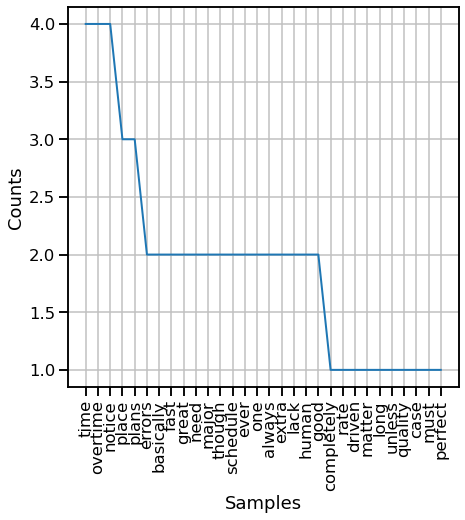

In [46]:
# Checking MyTokenizer on review sample
MyTK=MyTokenizer(print_=True, plot_=True, stopwords=sw2)

testMyTK=MyTK.tokenize(review_sample)

The original token list has 178 words
After the full manual cleanup, the review word list has 113 unique words


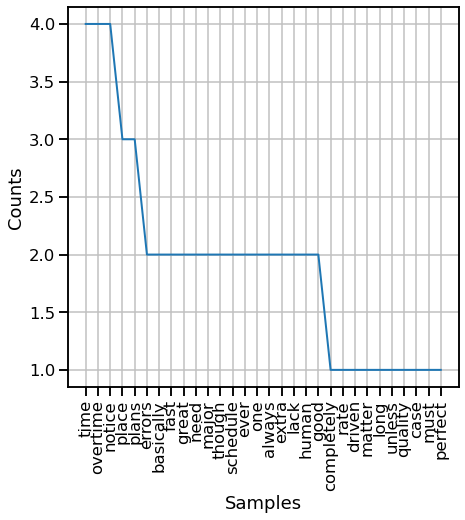

In [47]:
# checking how manual_cleanup function works on the same sample 
corpus_body_element_cleaned_man=manual_cleanup(review_sample, dict_replace, sw=sw2)

> Both methods result subsets are identical

### Tokenization, no lemmatization

Checking how MyTokenizer, RegExpTokenizer and TreebankWordTokenizer work without Lemmatization measured by the number of words left after tokenization with the same stopwords list.

#### MyTokenizer

After using


 our sample review has 113 unique words


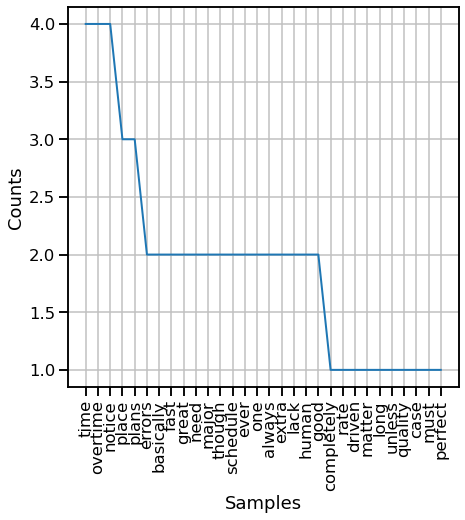

In [48]:
list_of_words_mytoken=review_tokenize_only(review_sample, MyTokenizer(), dict_replace, sw2)

#### RegExTokenizer

After using

 RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

 our sample review has 111 unique words


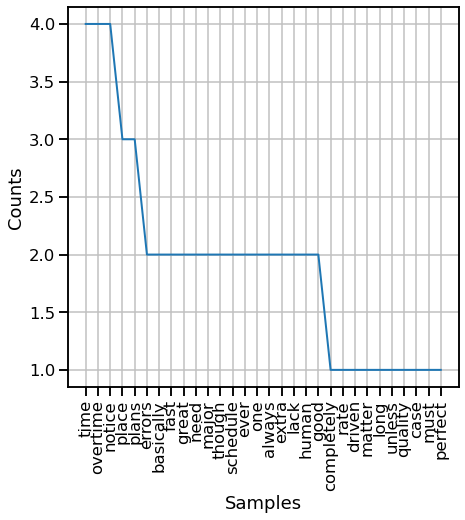

In [49]:
list_of_words_regex=review_tokenize_only(review_sample, RegexpTokenizer(pattern), dict_replace, sw2)

#### TreebankWordTokenizer

After using


 our sample review has 128 unique words


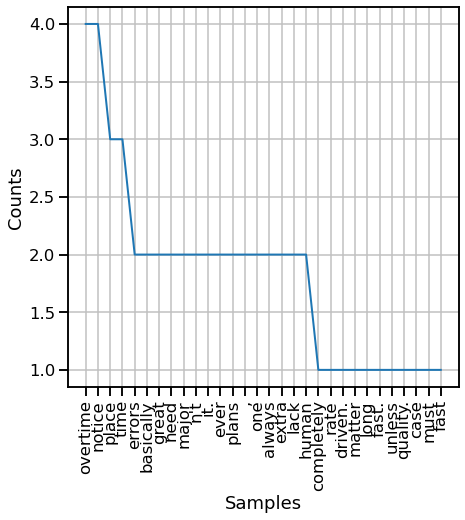

In [50]:
list_of_words_TreeBanktokenize=review_tokenize_only(review_sample, TreebankWordTokenizer(), dict_replace, sw2)

> MyTokenizer, RegExpTokenizer and TreebankWordTokenizer generated 113, 111 and 128 unique tokens respectively.

### Tokenization with lemmatization

Checking the performance of MyTokenizer, RegExpTokenizer and TreebankWordTokenizer tokenizers in conjunction with WordNetLemmatizer.

#### MyTokenizer & WordNetLemmatizer

After using

&
<WordNetLemmatizer>

 our sample review has 106 unique lemmas


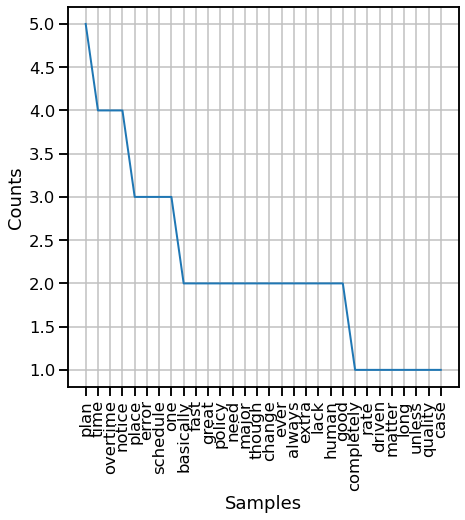

In [51]:
list_of_words_treebank_wordnet=review_tokenize_lemmatize(review_sample, MyTokenizer(), WordNetLemmatizer(), 
                                                         dict_replace, sw2)

#### TreeBankWordTokenizer & WordNetLemmatizer

After using

&
<WordNetLemmatizer>

 our sample review has 122 unique lemmas


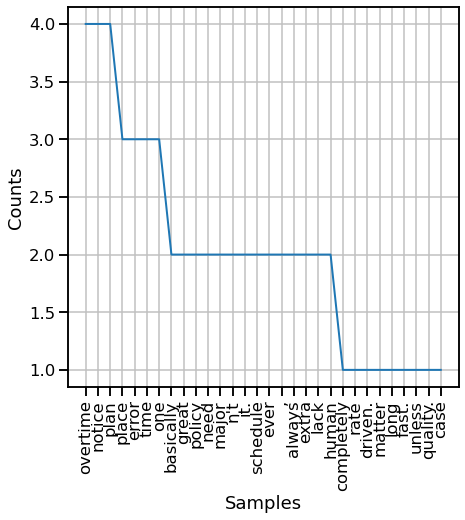

In [52]:
list_of_words_treebank_wordnet=review_tokenize_lemmatize(review_sample, TreebankWordTokenizer(), WordNetLemmatizer(), 
                                                         dict_replace, sw2)

#### RegExTokenizer & WordNetLemmatizer

After using

 RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)
&
<WordNetLemmatizer>

 our sample review has 104 unique lemmas


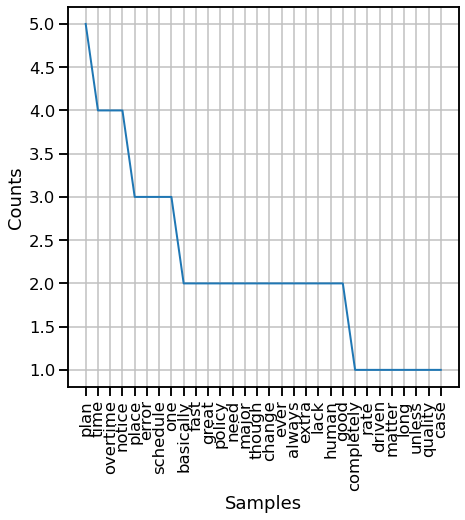

In [53]:
list_of_words_regex_wordnet=review_tokenize_lemmatize(review_sample, RegexpTokenizer(pattern), WordNetLemmatizer(),
                                                      dict_replace, sw2)

> MyTokenizer, RegExpTokenizer and TreebankWordTokenizer with WordNetLemmatizer generated 106, 122 and 104 unique tokens respectively.

### Comparing time for a phrase processing

In [54]:
regex_tok=RegexpTokenizer(pattern)
my_tok=MyTokenizer()
treebank_tok=TreebankWordTokenizer()

In [55]:
text1=regex_tok.tokenize(review_sample)

In [56]:
text2=my_tok.tokenize(review_sample)

In [57]:
text3=treebank_tok.tokenize(review_sample)

> Though the processing time of all three of Tokenizers with lemmatization is comparable RegExpTokenizer performed slightly better and generated slightly fewer tokens, which would result in fewer dimensions over the entire set. However, to make sure that my above assumptions are correct, I will do the vectorization with both tokenizers before making the final decision.

### Splitting and processing the corpus

In [58]:
text_from_first_option=' '.join(review_tokenize_lemmatize(review_sample, MyTokenizer(), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))
text_from_first_option

'place completely rate driven error basically matter long fast unless quality case must fast perfect great people policy need major overhaul though time easy request wont get much policy regard overtime scheduling schedule change ever change sometimes overtime notice hey hrs overtime tomorrow see ya major killer weekend plan appointment anything else think place gear around perfection speed one needing time ever always available extra time lack plan human error flow cause error course everyone work human life outside need present pay worth last minute notice schedule overtime family time plan cancel tell give day notice dont always default old memo say basically hr notice require extra shift even modify regular schedule insurance plan offer though actually really good hoop jump one great plan awesome coworkers good benefit place go look normal big company office politics absolute lack concern one entry'

In [59]:
text_from_second_option=' '.join(review_tokenize_lemmatize(review_sample, RegexpTokenizer(pattern), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))
text_from_second_option

'place completely rate driven error basically matter long fast unless quality case must fast perfect great people policy need major overhaul though time easy request get much policy regard overtime scheduling schedule change ever change sometimes overtime notice hey hrs overtime tomorrow see ya major killer weekend plan appointment anything else think place gear around perfection speed one needing time ever always available extra time lack plan human error flow cause error course everyone work human life outside need present pay worth last minute notice schedule overtime family time plan cancel tell give day notice always default old memo say basically hr notice require extra shift even modify regular schedule insurance plan offer though actually really good hoop jump one great plan awesome coworkers good benefit place go look normal big company office politics absolute lack concern one entry'

In [60]:
text_from_third_option=' '.join(review_tokenize_lemmatize(review_sample, TreebankWordTokenizer(), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))
text_from_third_option

"place completely rate driven. error basically matter long fast. unless quality. case must fast perfect. great people there. policy need major overhaul though. time easy request wo n't get much it. policy regard overtime scheduling schedule change ever changing. sometimes overtime notice `` hey 12hrs overtime tomorrow. see ya then. '' major killer weekend plan , appointment , anything else think doing. place gear around perfection speed one needing time ever always available extra time. lack plan human error flow cause error course everyone work human life outside need present for. pay worth last minute notice schedule overtime family time plan cancelled. tell give 7 day notice n't always default old memo say basically 24hr notice required. extra shift even modify regular schedule. insurance plan offer though actually really good. hoop jump one great plans. awesome coworkers good benefit place go it. look normal big company office politics absolute lack concern one entry"

> RegExTokenizer is the fastest one while MyTokenizer is the slowest.

## Feature Engineering, Vectorization

### Testing vectorizers

In [61]:
df_eda.tokens[0:10]

0    [worked, contractor, two, years, never, hired,...
1             [worst, place, ive, ever, worked, hands]
2    [compnay, good, benefits, even, small, pension...
3    [company, life, work, balance, everyday, full,...
4    [long, work, ball, drive, work, long, since, l...
5    [i’ve, watched, ball, morph, management, strat...
6    [great, job, little, disorganized, job, isn’t,...
7    [management, company, clueless, high, work, lo...
8    [ball, old, reputation, great, company, reputa...
9    [never, know, kind, day, going, work, days, re...
Name: tokens, dtype: object

In [62]:
# These words were listed at the very end of vectorized corpus body. I am adding them to the stop_words list
sw3=['ـــ',
 '⅞you',
 'いい経験でした',
 'いろいろな安全手順を守って',
 'チームの雰囲気はよかったです',
 '一ヶ月ぐらいだったけど',
 '仕事は海軍の時の同じで',
 '但是内部族裔斗争激烈',
 '但是能在年左右对财务方面有非常大的长进',
 '偶尔通宵',
 '工作量大', '晚上十点下班是正常的', 'ànd',
 'àreas',
 'ámbito',
 'área',
 'áreas',
 'çektiği',
 'échelle',
 'également',
 'él',
 'época',
 'époque',
 'équipe',
 'équipes',
 'ésta',
 'était',
 'ética',
 'étonnant',
 'évolutions',
 'ídolos',
 'índole',
 'óptimas',
 'ótima',
 'últimamente',
 'último',
 'única',
 'único',
 'únicome',
 'útil',
 'čtrnácti',
 'środka',
 'świata',
 'świetnie','正常积极地展现自己']

#### Vectorizers with MyTokenizer

In [63]:
# reviews_cleaned_mytokenizer=[]
# reviews_cleaned_mytokenizer=[' '.join(review_tokenize_lemmatize(str(review), MyTokenizer(), WordNetLemmatizer(),dict_replace, 
#                                                     sw2, plot_=False,print_=False)) for review in df_eda.tokens]

# with open('pickles/review_cleaned_mytokenizer.pkl', 'wb') as f:
#     pickle.dump(reviews_cleaned_mytokenizer, f)

In [64]:
# Due to the lengthy run of tokenization the result of tokenization with the cleanup was saved to a pickle file
with open('pickles/review_cleaned_mytokenizer.pkl', 'rb') as f:
    reviews_cleaned_mytokenizer = pickle.load(f)

In [65]:
len(reviews_cleaned_mytokenizer)

121620

##### CountVectorizer

In [66]:
vec_my1=CountVectorizer(stop_words=sw3)
text_vec_my1=vec_my1.fit_transform(reviews_cleaned_mytokenizer)

In [67]:
# feat_col=vec1.get_feature_names()
# feat_col[-32:]

In [68]:
# df_vec_my1=pd.DataFrame(text_vec_my1.todense(), columns=vec_my1.get_feature_names())
# df_vec_my1=df_vec_my1.sample(frac=0.01)
# df_vec_my1.to_pickle('pickles/df_vec_my1.pkl')

In [69]:
df_vec_my1=pd.read_pickle('pickles/df_vec_my1.pkl')
df_vec_my1

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoom,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyrtec
113946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### TfIdfVectorizer

In [70]:
vec_my2=TfidfVectorizer(stop_words=sw3)
text_vec_my2=vec_my2.fit_transform(reviews_cleaned_mytokenizer)

In [71]:
# df_vec_my2=pd.DataFrame(text_vec_my2.todense(), columns=vec_my2.get_feature_names())
# df_vec_my2=df_vec_my2.sample(frac=0.01)
# df_vec_my2.to_pickle('pickles/df_vec2_my.pkl')

In [72]:
df_vec_my2=pd.read_pickle('pickles/df_vec2_my.pkl')
df_vec_my2

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoom,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyrtec
26972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Vectorizers with RegExTokenizer

In [73]:
# reviews_cleaned_regextokenizer=[]
# reviews_cleaned_regextokenizer=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                     sw2,plot_=False,print_=False)) for review in df_eda.tokens]

# with open('review_cleaned_regextokenizer.pkl', 'wb') as f:
#     pickle.dump(pickles/reviews_cleaned_regextokenizer, f)

In [74]:
with open('pickles/review_cleaned_regextokenizer.pkl', 'rb') as f:
    reviews_cleaned_regextokenizer = pickle.load(f)

In [75]:
len(reviews_cleaned_regextokenizer)

121620

##### CountVectorizer

In [76]:
vec_regex1=CountVectorizer(stop_words=sw3)
text_vec_regex1=vec_regex1.fit_transform(reviews_cleaned_regextokenizer)

In [77]:
# df_vec_regex1=pd.DataFrame(text_vec_regex1.todense(), columns=vec_regex1.get_feature_names())
# df_vec_regex1=df_vec_regex1.sample(frac=0.01)
# df_vec_regex1.to_pickle('pickles/df_vec_regex1.pkl')

In [78]:
df_vec_regex1=pd.read_pickle('pickles/df_vec_regex1.pkl')
df_vec_regex1

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyka,zyrtec
113946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### TfIdfVectorizer

In [79]:
vec_regex2=TfidfVectorizer(stop_words=sw3)
text_vec_regex2=vec_regex2.fit_transform(reviews_cleaned_regextokenizer)

In [80]:
# df_vec_regex2=pd.DataFrame(text_vec_regex2.todense(), columns=vec_regex2.get_feature_names())
# df_vec_regex2=df_vec_regex2.sample(frac=0.01)
# df_vec_regex2.to_pickle('pickels/df_vec_regex2.pkl')

In [81]:
df_vec_regex2=pd.read_pickle('pickles/df_vec_regex2.pkl')
df_vec_regex2

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyka,zyrtec
26972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> They all work well; however, the process with MyTokenizer is slightly slower, and the final result has more word columns, 47281 vs. 46962. Therefore vectorization of tokens generated by RegExpTokenizer is a choice for further modeling.

### Creating and vectorizing training, test and validation sets

#### Splitting into training, test and validation sets

In [82]:
X=df_eda.tokens
y=df_eda.target

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=123,
                                                    test_size=0.25)

In [84]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

91215 30405 91215 30405


In [85]:
# token_reviews=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                      sw2,plot_=False,print_=False)) for review in X_train]

# with open('token_reviews.pkl', 'wb') as f:
#     pickle.dump(pickles/token_reviews, f)

In [86]:
with open('pickles/token_reviews.pkl', 'rb') as f:
    token_reviews = pickle.load(f)

In [87]:
len(token_reviews)

91215

In [88]:
token_reviews[10000]

'meat department busy department everyone give didnt upper management would tell policy immediate supervisor would contradict vice versa'

In [89]:
# Splitting X_Training into main training and validation sets

X_main_train, X_val, y_main_train, y_val = train_test_split(token_reviews,
                                                                        y_train,
                                                                        random_state=123,
                                                                        test_size=0.25)

In [90]:
len(X_main_train)

68411

#### Vectorization of the sets

##### CountVectorizer

In [91]:
vec_count=CountVectorizer(stop_words=sw3)
vec_count_X_train=vec_count.fit_transform(X_main_train)

In [92]:
# df_vec_count_train=pd.DataFrame(vec_count_X_train.todense(), columns=vec_count.get_feature_names())
# df_vec_count_train.set_index(y_main_train.index, inplace=True)
# df_vec_count_train.info()

In [93]:
a=list(vec_count.vocabulary_.values())
b=list(vec_count.vocabulary_.keys())
print(a[:50], b[:50])

[33109, 21463, 17065, 11209, 15706, 22735, 12422, 21290, 32039, 22166, 32873, 24028, 27083, 10754, 19346, 23963, 9459, 26976, 8209, 17758, 22244, 5406, 23367, 5542, 31584, 13890, 26317, 21055, 5237, 31979, 5907, 5242, 1663, 19286, 11032, 16593, 25357, 5727, 1305, 9237, 28402, 19643, 24728, 10994, 8091, 17032, 17448, 2965, 12219, 8325] ['young', 'people', 'look', 'first', 'job', 'pretty', 'good', 'pay', 'weekly', 'plus', 'would', 'recommend', 'someone', 'family', 'nice', 'recently', 'enforcement', 'social', 'distancing', 'mask', 'policy', 'company', 'punish', 'complain', 'violate', 'hour', 'shift', 'pandemic', 'combined', 'wear', 'constantly', 'come', 'area', 'never', 'felt', 'less', 'safe', 'conduct', 'annual', 'employee', 'survey', 'nothing', 'responses', 'feedback', 'dishearten', 'long', 'management', 'best', 'get', 'do']


In [94]:
vec_count_X_val=vec_count.transform(X_val)

In [95]:
# df_vec_count_val=pd.DataFrame(vec_count_X_val.todense(), columns=vec_count.get_feature_names())
# df_vec_count_val.set_index(y_val.index, inplace=True)
# df_vec_count_val.info()

##### TfIdfVectorizer

In [96]:
vec_tfidf=TfidfVectorizer(stop_words=sw3)
vec_tfidf_X_train=vec_tfidf.fit_transform(X_main_train)

In [97]:
# df_vec_tfidf_train=pd.DataFrame(vec_tfidf_X_train.todense(), columns=vec_tfidf.get_feature_names())
# df_vec_tfidf_train.set_index(y_main_train.index, inplace=True)
# df_vec_tfidf_train.info()

In [98]:
vec_tfidf_X_val=vec_tfidf.transform(X_val)

In [99]:
# df_vec_tfidf_val=pd.DataFrame(vec_tfidft_X_val.todense(), columns=vec_tfidf.get_feature_names())
# df_vec_tfidf_val.set_index(y_val.index, inplace=True)
# df_vec_tfidf_val.info()


# Model

In [100]:
# Keeping variable use frequently in the Modeling together.
datasets_list_count_val=[vec_count_X_train, vec_count_X_val, y_main_train, y_val]
datasets_list_tfidf_val=[vec_tfidf_X_train, vec_tfidf_X_val, y_main_train, y_val]
models_dict={'Classifier Name':[], 'Description':[],'Training or Val/Test': [],
             'Accuracy':[],'F1 Score':[], 'Saved model':[]}

## Default parameters models

### DummyClassifier model

In [101]:
#Building a dummy model with DummyClassifier.

dummy_num_model=DummyClassifier(strategy='most_frequent')
dummy_num_model.fit(vec_count_X_train,y_main_train)

DummyClassifier(strategy='most_frequent')

In [102]:
y_hat=dummy_num_model.predict(vec_count_X_val)
accuracy_score(y_val,y_hat)
f1_score(y_val, y_hat, average="weighted")

0.426699952872438

***************************************
DummyClassifier(strategy='most_frequent')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13360
           2       0.00      0.00      0.00     15112
           3       0.58      1.00      0.74     39939

    accuracy                           0.58     68411
   macro avg       0.19      0.33      0.25     68411
weighted avg       0.34      0.58      0.43     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4489
           2       0.00      0.00      0.00      5072
           3       0.58      1.00      0.73     13243

    accuracy                           0.58     22804
   macro avg       0.19      0.33      0.24     22804
weig

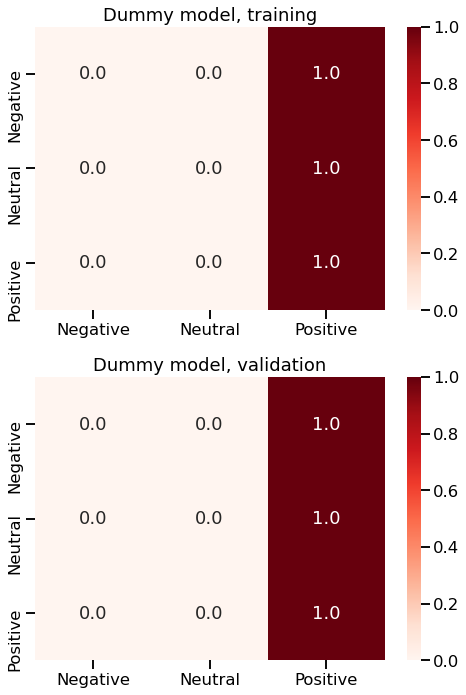

In [103]:
simple_model_validation(dummy_num_model, datasets_list_count_val, 'Dummy model, training', 'Dummy model, validation')

In [104]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Dummy  with CountVectorizer',
                                         'dummy_num_model',
                                         datasets_list_count_val, 
                                         dummy_num_model,
                                         'not saved')

In [105]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved


> The model is for comparison purpose only

### MultinomialNB model

In [106]:
mnb1=MultinomialNB()

mnb1.fit(vec_count_X_train,y_main_train)
cross_val_score(mnb1, vec_count_X_train,y_main_train, cv=5, scoring='f1_macro')

array([0.56937929, 0.56825015, 0.57870884, 0.56253266, 0.56795986])

In [107]:
mnb1.classes_

array(['1', '2', '3'], dtype='<U1')

In [108]:
prior_1=y_train.value_counts()[0]/len(y_train)
prior_2=y_train.value_counts()[1]/len(y_train)
prior_3=y_train.value_counts()[2]/len(y_train)
print(round(prior_1,4), round(prior_2,4), round(prior_3,4))

0.583 0.2213 0.1957


***************************************
MultinomialNB()
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.66      0.69      0.68     13360
           2       0.55      0.35      0.43     15112
           3       0.79      0.88      0.83     39939

    accuracy                           0.73     68411
   macro avg       0.66      0.64      0.64     68411
weighted avg       0.71      0.73      0.71     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.60      0.65      0.62      4489
           2       0.38      0.23      0.28      5072
           3       0.76      0.86      0.80     13243

    accuracy                           0.67     22804
   macro avg       0.58      0.58      0.57     22804
weighted avg       0.64      0

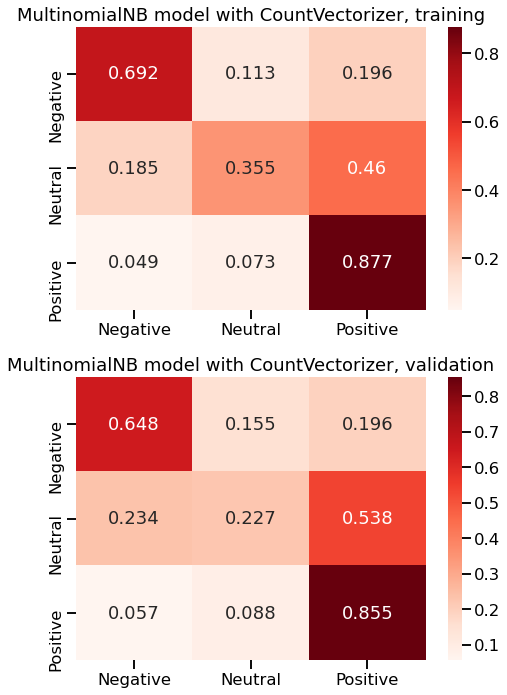

In [109]:
simple_model_validation(mnb1, datasets_list_count_val, 'MultinomialNB model with CountVectorizer, training',
                        'MultinomialNB model with CountVectorizer, validation')

In [110]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'MultinomialNB model with CountVectorizer',
                                         'mnb1',
                                         datasets_list_count_val, 
                                         mnb1,
                                         'not saved; fast fitting')

In [111]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting


> MNB model with default parameters worked relatively well but it is over-fitted.

### LogisticRegressionCV

#### With CountVectorized set

In [112]:
# lrcv1=LogisticRegressionCV(max_iter=1000, random_state=123, scoring='f1_macro')
# lrcv1.fit(vec_count_X_train,y_main_train)

In [113]:
# filename = 'models/LRCV_count_fitted.pkl'
# pickle.dump(lrcv1, open(filename, 'wb'))

In [114]:
filename = 'models/LRCV_count_fitted.pkl'
lrcv1_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(max_iter=1000, random_state=123, scoring='f1_macro')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.78      0.68      0.73     13360
           2       0.68      0.37      0.48     15112
           3       0.77      0.94      0.85     39939

    accuracy                           0.76     68411
   macro avg       0.74      0.66      0.68     68411
weighted avg       0.75      0.76      0.74     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.65      0.57      0.61      4489
           2       0.38      0.19      0.26      5072
           3       0.73      0.90      0.81     13243

    accuracy                           0.68     22804
   macro avg       0.58   

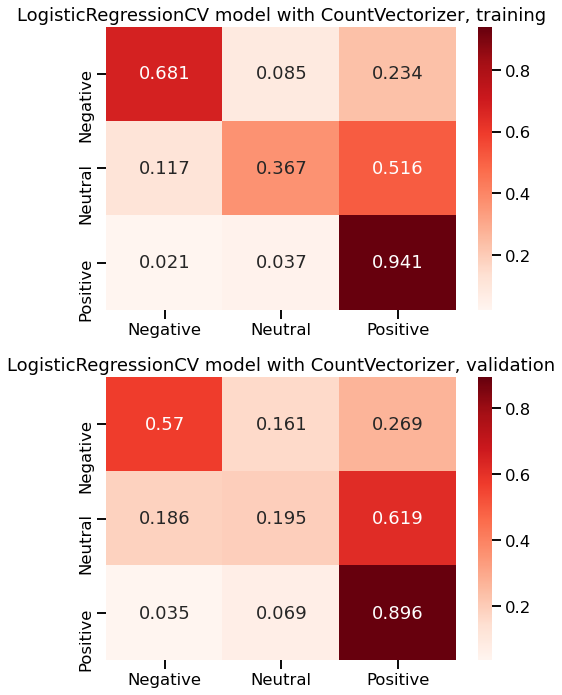

In [115]:
simple_model_validation(lrcv1_loaded_model, datasets_list_count_val,
                        'LogisticRegressionCV model with CountVectorizer, training',
                        'LogisticRegressionCV model with CountVectorizer, validation')

In [116]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogisticRegressionCV model with CountVectorizer',
                                         'lrcv1_loaded_model',
                                         datasets_list_count_val, 
                                         lrcv1_loaded_model,
                                         'models/LRCV_count_fitted.pkl')

In [117]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl


> LRCV model with CountVectorized features and default classifier parameters worked better than MNB model on the training set, but it shows more unsatisfactory performance on the validation set and is over-fitted even more.

#### With TfIdfVectorized set

In [118]:
# lrcv2=LogisticRegressionCV(max_iter=400, random_state=123, n_jobs=-1, scoring='f1_macro')
# lrcv2.fit(vec_tfidf_X_train,y_main_train)

# filename = 'models/LRCV_tfidf_fitted.pkl'
# pickle.dump(lrcv2, open(filename, 'wb'))

In [119]:
filename = 'models/LRCV_tfidf_fitted.pkl'
lrcv2_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(max_iter=400, n_jobs=-1, random_state=123,
                     scoring='f1_macro')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.71      0.74     13360
           2       0.69      0.40      0.50     15112
           3       0.79      0.94      0.86     39939

    accuracy                           0.77     68411
   macro avg       0.75      0.68      0.70     68411
weighted avg       0.76      0.77      0.76     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.63      0.59      0.61      4489
           2       0.38      0.20      0.27      5072
           3       0.74      0.88      0.81     13243

    accuracy                           0.68     2

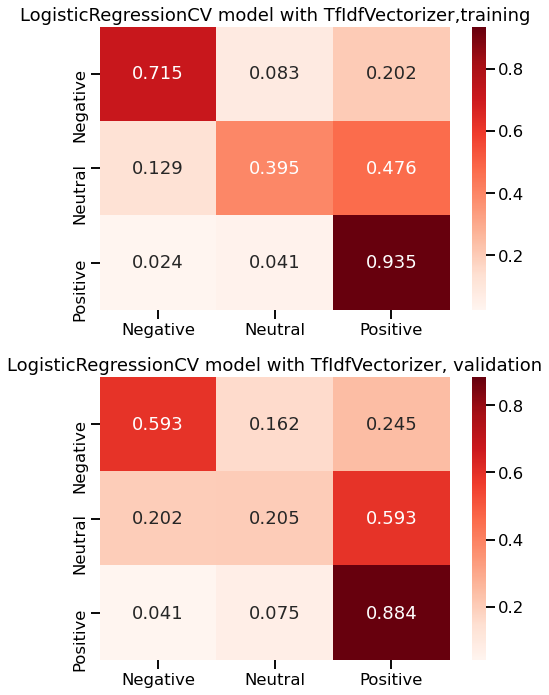

In [120]:
simple_model_validation(lrcv2_loaded_model, datasets_list_tfidf_val,
                        'LogisticRegressionCV model with TfIdfVectorizer,training',
                        'LogisticRegressionCV model with TfIdfVectorizer, validation')

In [121]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogisticRegressionCV model with TfIdfVectorizer',
                                         'lrcv2_loaded_model',
                                         datasets_list_tfidf_val, 
                                         lrcv2_loaded_model,
                                         'models/LRCV_tfidf_fitted.pkl')

In [122]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl


> LRCV model with TfIdfVectorized features and default classifier parameters worked better than MNB and the previous LRCV model on the training set, but it shows more unsatisfactory performance on the validation set and is over-fitted even more.

### XGBClassifier

#### With CountVectorized set

In [123]:
xgb1=XGBClassifier(multi='softmax', verbosity=0, njobs=-1, seed=123, scoring='f1_macro')

xgb1.fit(vec_count_X_train,y_main_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.58      0.66     13360
           2       0.70      0.22      0.

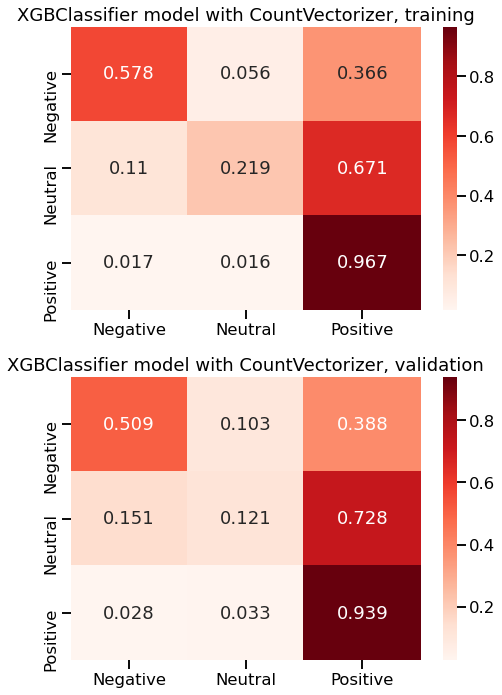

In [124]:
simple_model_validation(xgb1, datasets_list_count_val,
                        'XGBClassifier model with CountVectorizer, training',
                        'XGBClassifier model with CountVectorizer, validation')

In [125]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'XGBClassifier model with CountVectorizer',
                                         'xgb1',
                                         datasets_list_count_val, 
                                         xgb1,
                                         'not saved; fast fitting')

In [126]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> XGBoostClassifier with default parameters and CountVectorized tokens performed poorly, the worst so far.

#### With TfIdfVectorized set

In [127]:
xgb2=XGBClassifier(multi='softmax', seed=123, verbosity=0, njobs=-1, scoring='f1_macro')
xgb2.fit(vec_tfidf_X_train,y_main_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.60      0.68     13360
           2       0.75      0.24      0.

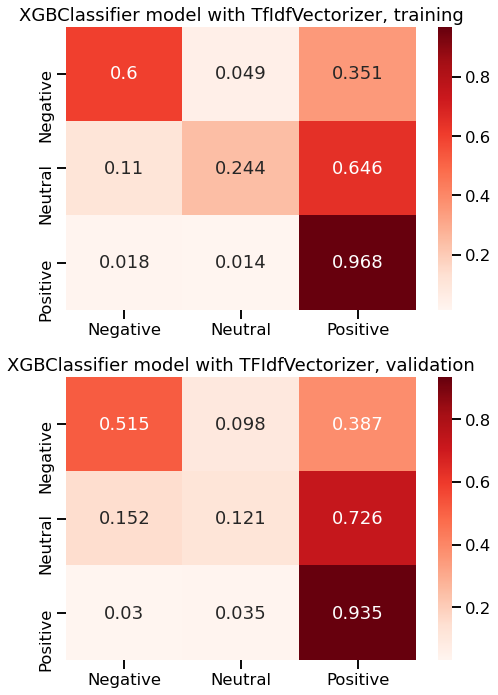

In [128]:
simple_model_validation(xgb2, datasets_list_tfidf_val,
                        'XGBClassifier model with TfIdfVectorizer, training',
                        'XGBClassifier model with TFIdfVectorizer, validation')

In [129]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'XGBClassifier model with TFIdfVectorizer',
                                         'xgb2',
                                          datasets_list_tfidf_val, 
                                          xgb2,
                                         'not saved; fast fitting')

In [130]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> XGBoostClassifier with default parameters and TfIdfVectorized tokens performed slightly better than the previous model but no better than MNB or LRCV classifiers.

### Summary of Modeling Section

None of the models performed remarkably well:
* MultinomialNB model with CountVectoried dataset was very fast but performed slightly worse than LogisticRegression models (both count-vectorized and tdidf-vectorized) in terms of accuracy
* MultinomialNB model has the best ability to identify Neutral reviews, which seems to be a problem for other models.
* Logistic regression models took the most time to train but produced better results.
* MultinomialNB model does not have many parameters to tune the model except the alpha smoothing parameter
* Logistic regression can be tuned up on many more parameters, but the time running each variation might become prohibitive.
* XGBClassifier models (both count-vectorized and tdidf-vectorized) performed slightly worse than MultinomialNB model. However, XGBCalssifier has more hyperparameters to tune it and therefore might be a good candidate for a grid search considering the relatively short time to run the fit.

**The final step is to run a grid search for**<br>

   1. MultinomialNB classifie
       * alpha hyperparameter in MultinomialNB classifier.    
   2. XGBoostCalssifier
       * booster (gbtree)
       * gamma (0, 0.1, 1, 10)
       * eta (aka learning rate) (0.1, 0.5, 1)
       * subsample (0.1, 0.5,0.7, 1)
       * sampling method (uniform, gradient_based)
       * tree_method (approx, hist, gpu_hist)
       * lambda (0,1)
       * alpha (0,1)


## GridSearch for Best Models

### GridsearchCV for XGBClassifier with count-vectorized dataset

In [131]:
# params = {'eta': [0.1, 0.5, 1],
#           'gamma':[0, 0.1, 1, 10],
#           'lambda':[0,1],
#            'alpha': [0,1],
#            'subsample': [0.1, 0.5, 0.7, 1], 'sampling_method': ['uniform', 'gradient_based'],
#            'tree_method': ['approx', 'hist', 'gpu_hist']}


# gridsearch = GridSearchCV(XGBClassifier(multi='softmax', random_state=123, booster='gbtree'), params, n_jobs=-1,
#                           cv=3, verbose=0, scoring = 'f1_macro')

# gridsearch.fit(vec_count_X_train, y_main_train)

> This gridsearch ran for 1.5 hour so it is pretty expensive computationally

In [132]:
# joblib.dump(gridsearch.best_estimator_, 'models/XGB_best.joblib')

In [133]:
# gridsearch.best_score_

In [134]:
# gridsearch.best_params_

In [135]:
# xgb5=XGBClassifier(multi='softmax', verbosity=0, njobs=-1, seed=123,
#                    booster='gbtree',
#                    eta=1,
#                    gamma=0.1,
#                    reg_lambda=1,
#                    reg_alpha=1,
#                    sampling_method='uniform',
#                    subsample=0.7,
#                    tree_method='hist',
#                    scoring='f1_macro')

# xgb5.fit(vec_count_X_train,y_main_train)

In [136]:
# filename = 'models/XGB_best_count_fitted.pkl'
# pickle.dump(xgb5, open(filename, 'wb'))

In [137]:
filename = 'models/XGB_best_count_fitted.pkl'
xgb5_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=1, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=None, scoring='f1_macro', seed=123,
              subsample=0.7, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.78      0.67      0.72     13360
           2       0.70      0.40      0.51     15112
   

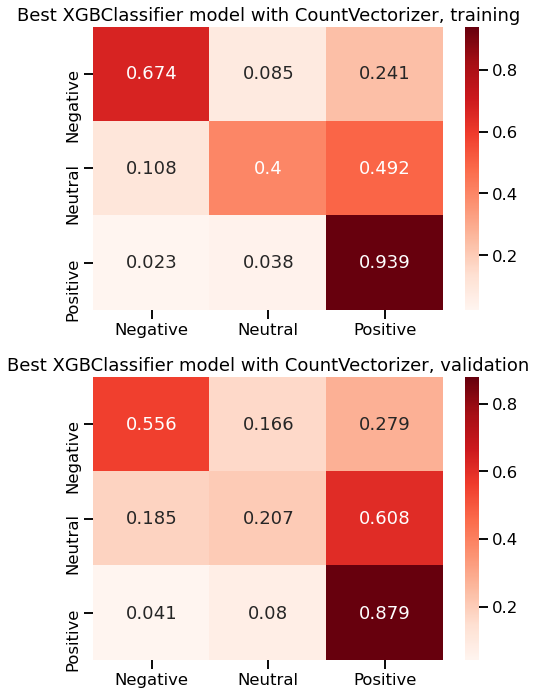

In [138]:
simple_model_validation(xgb5_loaded_model, datasets_list_count_val,
                        'Best XGBClassifier model with CountVectorizer, training',
                        'Best XGBClassifier model with CountVectorizer, validation')

In [139]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Best XGBClassifier model with CountVectorizer',
                                         'xgb5_loaded_model',
                                          datasets_list_count_val, 
                                          xgb5_loaded_model,
                                         'models/XGB_best_count_fitted.pkl')

In [140]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> The best XGB model performance is better than the performance of the XGB model with default parameters but is it very overfitted.

### GridSearch for MultinomialNB Classifier

In [141]:
params = {'alpha':[0,0.1,0.3,0.5,0.7, 1]}


gridsearch = GridSearchCV(MultinomialNB(), params, n_jobs=-1,
                          cv=3, verbose=0, scoring = 'f1_macro')

gridsearch.fit(vec_count_X_train, y_main_train)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1]},
             scoring='f1_macro')

In [142]:
gridsearch.best_score_

0.5771297387176196

In [143]:
gridsearch.best_params_

{'alpha': 0.3}

In [144]:
mnb2=MultinomialNB(alpha=0.3)
mnb2.fit(vec_count_X_train,y_main_train)

MultinomialNB(alpha=0.3)

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.68      0.71      0.69     13360
           2       0.56      0.45      0.50     15112
           3       0.81      0.86      0.83     39939

    accuracy                           0.74     68411
   macro avg       0.68      0.67      0.67     68411
weighted avg       0.73      0.74      0.73     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4489
           2       0.36      0.28      0.31      5072
           3       0.77      0.82      0.79     13243

    accuracy                           0.66     22804
   macro avg       0.58      0.58      0.58     22804
weighted avg       0.

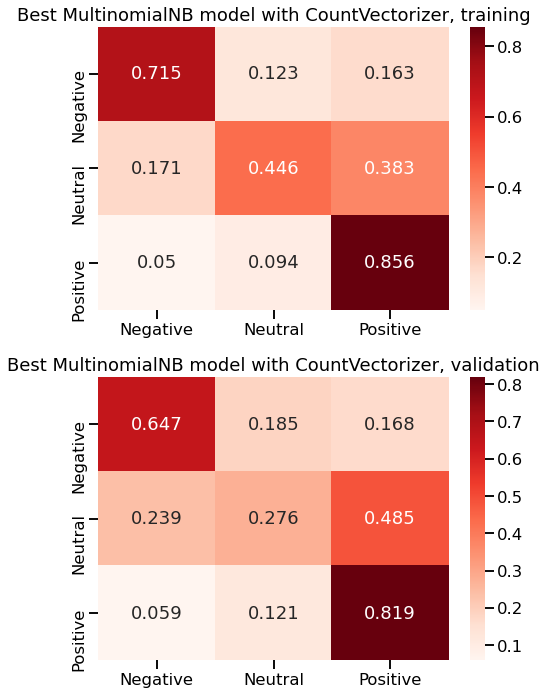

In [145]:
simple_model_validation(mnb2, datasets_list_count_val,
                        'Best MultinomialNB model with CountVectorizer, training',
                        'Best MultinomialNB model with CountVectorizer, validation')

In [146]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Best MNBClassifier model with CountVectorizer',
                                         'mnb2',
                                          datasets_list_count_val, 
                                          mnb2,
                                         'not saved, fast fitting model')

In [147]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> The best MNB model performance is the best so far, but it also shows over-fitting. While it identifies positive reviews well, it lacks the ability to identify neutral reviews. The model identified only 27.6% of neutral reviews correctly.

### GridSearch for LogisticRegressionCV classifier

In [148]:
# params = {'solver' : ['newton-cg', 'lbfgs', 'sag']}


# gridsearch = GridSearchCV(LogisticRegressionCV(max_iter=400, random_state=123,
#                                                penalty='l2',
#                                                class_weight='balanced',
#                                                multi_class='multinomial'), params, n_jobs=-1,
#                           cv=3, verbose=2, scoring = 'f1_macro')

# gridsearch.fit(vec_tfidf_X_train,y_main_train)

In [149]:
# gridsearch.best_score_

In [150]:
# gridsearch.best_params_

> Due to the fact that the gridsearch ran for close to 20 minutes I am saving the gridsearch.best_estamator to a joblib file. 

In [151]:
# joblib.dump(gridsearch.best_estimator_, 'models/LRCV_best_tfidf.joblib')

In [152]:
# lrcv3=LogisticRegressionCV(max_iter=400, random_state=123,
#                            class_weight='balanced',
#                            multi_class='multinomial',
#                            penalty='l2',
#                            solver='newton-cg',
#                            scoring='f1_macro')
# lrcv3.fit(vec_tfidf_X_train,y_main_train)

> The fitting of the model took 12.5 minutes to fit the data and due to that fact I am saving it to a pickle file to use later.

In [153]:
# filename = 'models/LRCV_best_tfidf_fitted.pkl'
# pickle.dump(lrcv3, open(filename, 'wb'))

In [154]:
filename = 'models/LRCV_best_tfidf_fitted.pkl'
lrcv3_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=400,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.62      0.76      0.68     13360
           2       0.44      0.53      0.48     15112
           3       0.86      0.73      0.79     39939

    accuracy                           0.69     68411
   macro avg       0.64      0.67      0.65     68411
weighted avg       0.72      0.69      0.70     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.56      0.70      0.62      4489
           2       0.34      0.41      0.37      5072
           3       0.8

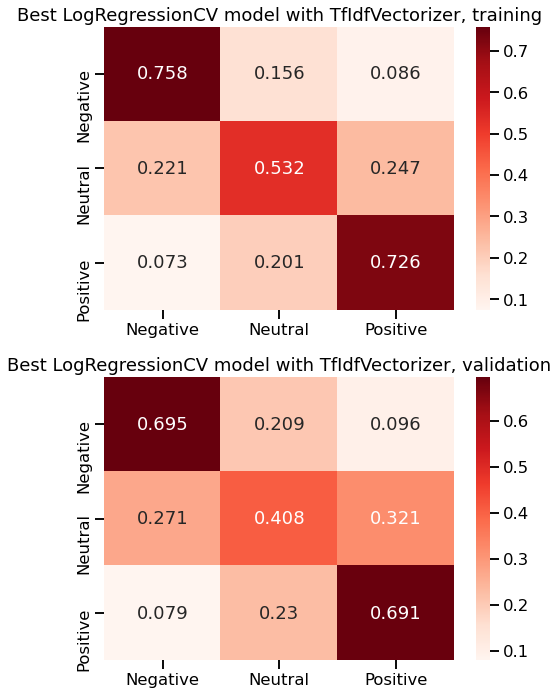

In [155]:
simple_model_validation(lrcv3_loaded_model, datasets_list_tfidf_val,
                        'Best LogRegressionCV model with TfIdfVectorizer, training',
                        'Best LogRegressionCV model with TfIdfVectorizer, validation')

In [156]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogRegressionCV model with TfIdfVectorizer, best params',
                                         'lrcv3_loaded_model',
                                         datasets_list_tfidf_val,
                                         lrcv3_loaded_model,
                                         'models/LRCV_best_tfidf_fitted.pkl')

In [157]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> The LRCV model with best parameters displays the best performance among all the models so far. It is also the least over-fitted.

>The best performing models are 
> * LogRegressionCV model with TfIdfVectorizer, best params<br>
> * Best MNBClassifier model with CountVectorizer

> Both models use the same full features dataset

## Reduction of Features, addition of bigrams

> The models tested above use the full datasets of 46962 word vectors. The next step in the process is to test if decreasing the number of features would reduce the over-fitting and would generate more meaningful models.

### Reduction of features

In [158]:
# Omitting words that are used in more than 99% of the reviews and in less than 1% of the reviews. Adding bigrams to the 
# features


vec_count2=CountVectorizer(stop_words=sw3, min_df=0.01, max_df=0.99, ngram_range=(1, 3))
vec_count2_X_train=vec_count2.fit_transform(X_main_train)


In [159]:
df_vec_count2=pd.DataFrame(vec_count2_X_train.todense(), columns=vec_count2.get_feature_names())
df_vec_count2.head()

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [160]:
vec_count2_X_val=vec_count2.transform(X_val)
df_vec_count2_val=pd.DataFrame(vec_count2_X_val.todense(), columns=vec_count2.get_feature_names())
df_vec_count2_val

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22802,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
vec_tfidf2=TfidfVectorizer(stop_words=sw3, min_df=0.01, max_df=0.99, ngram_range=(1, 3))
vec_tfidf2_X_train=vec_tfidf2.fit_transform(X_main_train)

In [162]:
df_vec_tfidf2=pd.DataFrame(vec_tfidf2_X_train.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2.head()

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.215598,0.346607,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.415685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.417516,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [163]:
vec_tfidf2_X_val=vec_tfidf2.transform(X_val)
df_vec_tfidf2_val=pd.DataFrame(vec_tfidf2_X_val.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2_val

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.264682,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.339014,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.106061,0.0,0.0,0.000000,0.0,0.0,0.080459,0.0,...,0.0,0.0,0.106528,0.0,0.000000,0.0,0.0,0.0,0.079393,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22800,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22801,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22802,0.0,0.176609,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [164]:
datasets_list_count2_val=[vec_count2_X_train, vec_count2_X_val, y_main_train, y_val]
datasets_list_tfidf2_val=[vec_tfidf2_X_train, vec_tfidf2_X_val, y_main_train, y_val]

> As the result of the process only 406 words and bigrams are left in the feature sets

### MNBClassifier

In [165]:
params = {'alpha':[0,0.1,0.3,0.5,0.7, 1]}


gridsearch = GridSearchCV(MultinomialNB(), params, n_jobs=-1,
                          cv=3, verbose=0, scoring = 'f1_macro')

gridsearch.fit(vec_count2_X_train, y_main_train)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1]},
             scoring='f1_macro')

In [166]:
gridsearch.best_score_

0.5449139255229211

In [167]:
gridsearch.best_params_

{'alpha': 0.3}

In [168]:
mnb3=MultinomialNB(alpha=0.3)
mnb3.fit(vec_count2_X_train,y_main_train)

MultinomialNB(alpha=0.3)

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.58     13360
           2       0.38      0.23      0.29     15112
           3       0.75      0.82      0.78     39939

    accuracy                           0.65     68411
   macro avg       0.56      0.56      0.55     68411
weighted avg       0.63      0.65      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.63      0.58      4489
           2       0.36      0.21      0.26      5072
           3       0.74      0.81      0.78     13243

    accuracy                           0.64     22804
   macro avg       0.55      0.55      0.54     22804
weighted avg       0.

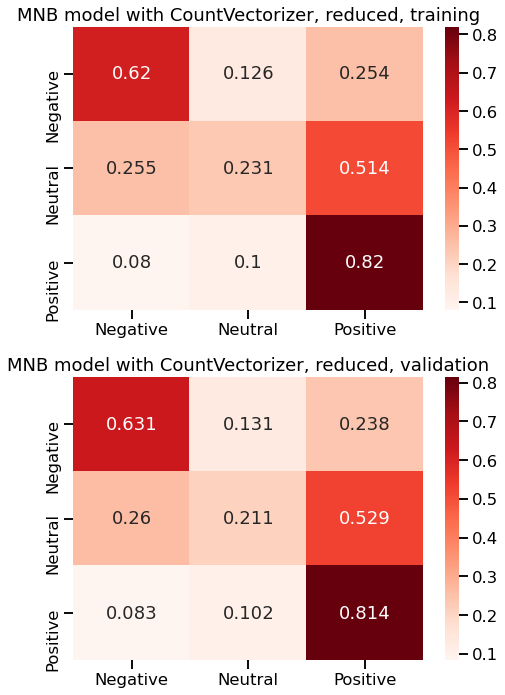

In [169]:
simple_model_validation(mnb3, datasets_list_count2_val,
                        'MNB model with CountVectorizer, reduced, training',
                        'MNB model with CountVectorizer, reduced, validation')


In [170]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'MNB model with CountVectorizer, reduced',
                                         'mnb3',
                                          datasets_list_count2_val,
                                          mnb3,
                                         'not saved, fast fitting')

In [171]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> The best MNB model with 406 features is much less over-fitted though the performance dropped a bit.

### LogisticRegressionCVClassifier

In [172]:
# params = {'solver' : ['newton-cg', 'lbfgs', 'sag','lblinear'],
#          'penalty': ['l1','l2']}


# gridsearch = GridSearchCV(LogisticRegressionCV(max_iter=1000, random_state=123,
#                                                class_weight='balanced',
#                                                multi_class='multinomial'), params, n_jobs=-1,
#                           cv=3, verbose=2, scoring = 'f1_macro')

# gridsearch.fit(vec_tfidf2_X_train,y_main_train)

In [173]:
# gridsearch.best_params_

In [174]:
# lrcv4=LogisticRegressionCV(max_iter=1000, random_state=123,
#                            class_weight='balanced',
#                            multi_class='multinomial',
#                            penalty='l2',
#                            solver='newton-cg',
#                            scoring='f1_macro')
# lrcv4.fit(vec_tfidf2_X_train,y_main_train)

In [175]:
# filename = 'models/LRCV_best_tfidf_red_fitted.pkl'
# pickle.dump(lrcv4, open(filename, 'wb'))

In [176]:
filename = 'models/LRCV_best_tfidf_red_fitted.pkl'
lrcv4_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59     13360
           2       0.34      0.41      0.37     15112
           3       0.81      0.67      0.73     39939

    accuracy                           0.61     68411
   macro avg       0.56      0.59      0.56     68411
weighted avg       0.65      0.61      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59      4489
           2       0.33      0.39      0.35      5072
           3       0.

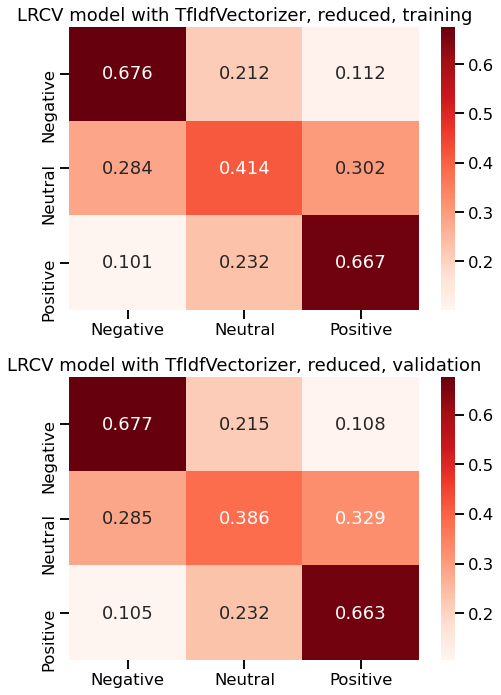

In [177]:
simple_model_validation(lrcv4_loaded_model, datasets_list_tfidf2_val,
                        'LRCV model with TfIdfVectorizer, reduced, training',
                        'LRCV model with TfIdfVectorizer, reduced, validation')


In [178]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LRCV model with TfIdfVectorizer, reduced',
                                         'lrcv4_loaded_model',
                                          datasets_list_tfidf2_val,
                                          lrcv4_loaded_model,
                                         'models/LRCV_best_tfidf_red_fitted.pkl')

In [179]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


> LRCV best parameters models with 406 features display much less over-fitting than the similar model with the full features set. Its' performance dropped slightly. The fact of low over-fitting level makes it the best model so far.

## Final testing

> Comparing the performance of the optimized MultinomialNB and LogisticRegressionCV models with reduced feature sets with the original (leak-proof) test dataset.

X_train, X_test, y_train, y_test

In [180]:
# token_reviews_test=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                      sw2, plot_=False,print_=False)) for review in X_test]


In [181]:
# with open('token_reviews_test.pkl', 'wb') as f:
#     pickle.dump(token_reviews_test, f)

In [182]:
with open('token_reviews_test.pkl', 'rb') as f:
    token_reviews_test = pickle.load(f)

In [183]:
len(token_reviews_test)

30405

In [184]:
vec_count_X_test=vec_count.transform(token_reviews_test)
df_vec_count_test=pd.DataFrame(vec_count_X_test.todense(), columns=vec_count.get_feature_names())
df_vec_count_test

,aa,aaa,aaeak,aaked,aal,aalarm,aam,aamazon,aand,aareally,...,zone,zoningkeeping,zoo,zoom,zos,zsecure,zulily,zurich,zyka,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
vec_tfidf_X_test=vec_tfidf.transform(token_reviews_test)
df_vec_tfidf_test=pd.DataFrame(vec_tfidf_X_test.todense(), columns=vec_tfidf.get_feature_names())
df_vec_tfidf_test

,aa,aaa,aaeak,aaked,aal,aalarm,aam,aamazon,aand,aareally,...,zone,zoningkeeping,zoo,zoom,zos,zsecure,zulily,zurich,zyka,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
vec_count2_X_test=vec_count2.transform(token_reviews_test)
df_vec_count2_test=pd.DataFrame(vec_count2_X_test.todense(), columns=vec_count2.get_feature_names())
df_vec_count2_test

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
30401,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30402,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30403,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
vec_tfidf2_X_test=vec_tfidf2.transform(token_reviews_test)
df_vec_tfidf2_test=pd.DataFrame(vec_tfidf2_X_test.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2_test

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.404432,0.0,0.0,0.00000,0.303212
30401,0.401454,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
30402,0.000000,0.0,0.0,0.395509,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
30403,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.37829,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000


In [188]:
datasets_list_count2_test=[vec_count2_X_train, vec_count2_X_test, y_main_train, y_test]
datasets_list_tfidf2_test=[vec_tfidf2_X_train, vec_tfidf2_X_test, y_main_train, y_test]

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.58     13360
           2       0.38      0.23      0.29     15112
           3       0.75      0.82      0.78     39939

    accuracy                           0.65     68411
   macro avg       0.56      0.56      0.55     68411
weighted avg       0.63      0.65      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.57      5899
           2       0.37      0.22      0.28      6666
           3       0.75      0.82      0.78     17840

    accuracy                           0.65     30405
   macro avg       0.55      0.55      0.54     30405
weighted avg       0.

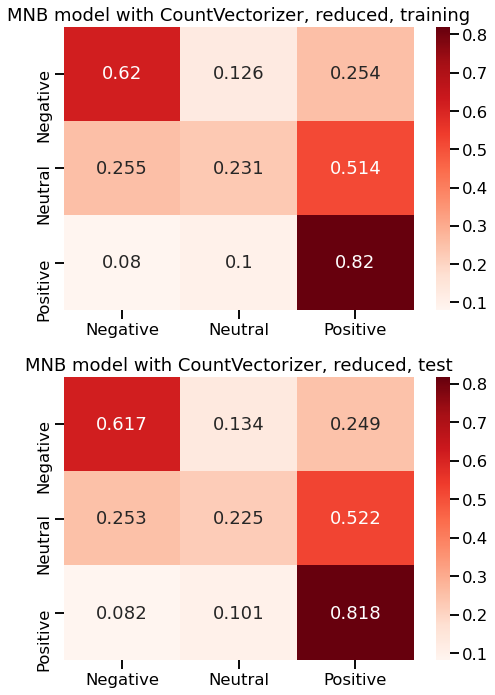

In [189]:
simple_model_validation(mnb3, datasets_list_count2_test,
                        'MNB model with CountVectorizer, reduced, training',
                        'MNB model with CountVectorizer, reduced, test')


***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59     13360
           2       0.34      0.41      0.37     15112
           3       0.81      0.67      0.73     39939

    accuracy                           0.61     68411
   macro avg       0.56      0.59      0.56     68411
weighted avg       0.65      0.61      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59      5899
           2       0.33      0.41      0.36      6666
           3       0.

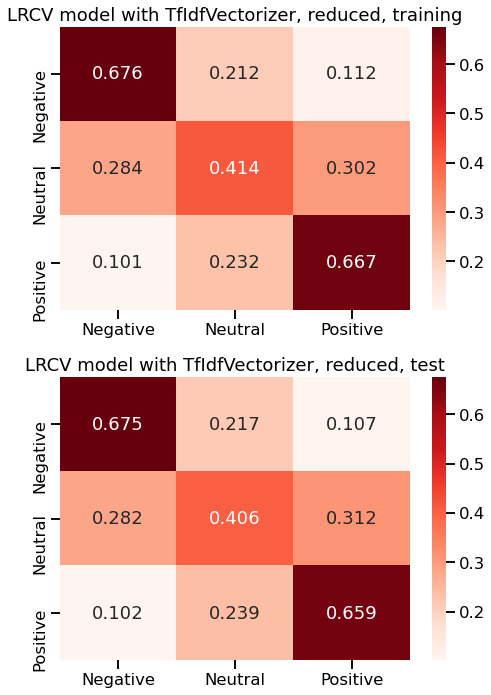

In [190]:
simple_model_validation(lrcv4_loaded_model, datasets_list_tfidf2_test,
                        'LRCV model with TfIdfVectorizer, reduced, training',
                        'LRCV model with TfIdfVectorizer, reduced, test')


### Best model

> The best model, LogisticRegressionCV with reduced feature set, is selected because it is the most balanced out of all models tested. It identified the highest percentage of neutral reviews in the test dataset while maintaining a relatively good performance identifying reviews in positive and negative categories. It is also the least over-fitted of the models.

# iNterpret

## Feature Importance

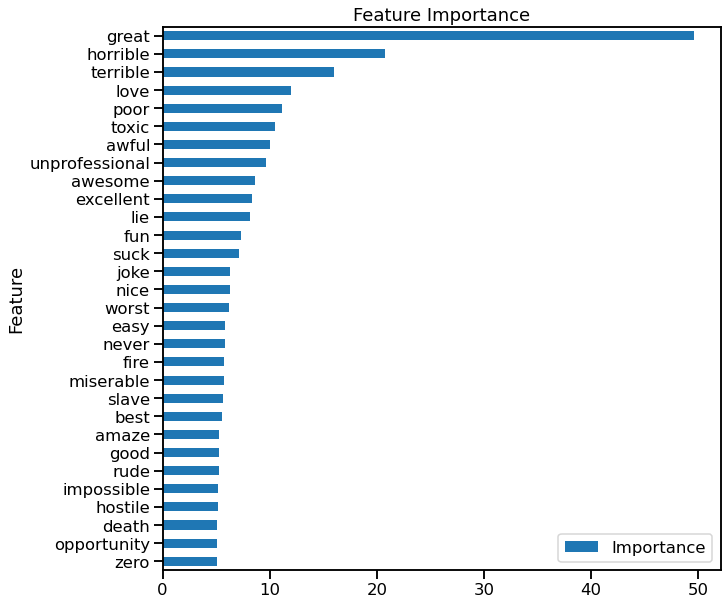

,Feature,Importance,Coefficient
33185,zero,5.048676,1.619126
20327,opportunity,5.103781,-1.629982
7109,death,5.112410,1.631671
13855,hostile,5.173052,1.643463
14444,impossible,5.193681,1.647443
25260,rude,5.227099,1.653856
12422,good,5.302137,-1.668110
1030,amaze,5.306160,-1.668869
2965,best,5.564141,-1.716343
26773,slave,5.654331,1.732422


In [191]:
get_importance_logreg(lrcv3_loaded_model, df_vec_tfidf_test, top_n=30)

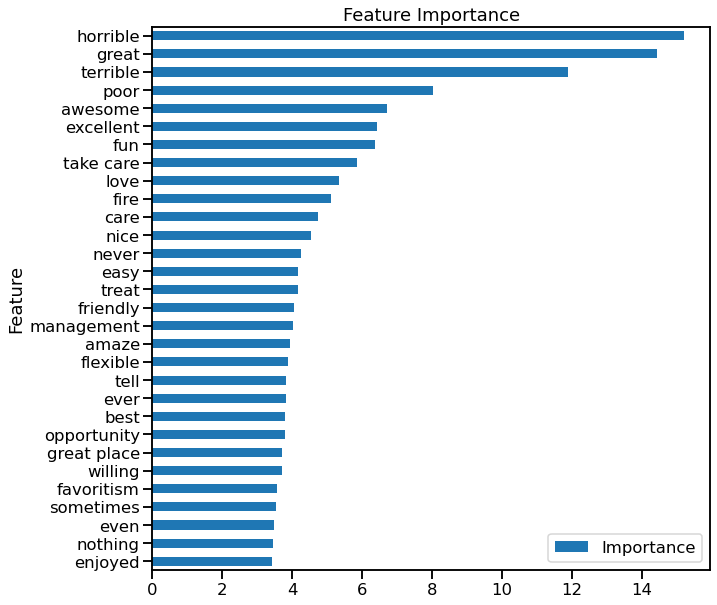

,Feature,Importance,Coefficient
99,enjoyed,3.410194,-1.226769
247,nothing,3.444332,1.236730
103,even,3.478316,1.246548
338,sometimes,3.521162,-1.258791
122,favoritism,3.558741,1.269407
388,willing,3.717097,-1.312943
154,great place,3.717795,-1.313131
256,opportunity,3.783379,-1.330618
34,best,3.799771,-1.334941
104,ever,3.816901,1.339439


In [192]:
get_importance_logreg(lrcv4_loaded_model, df_vec_tfidf2_test,top_n=30)

> Both LRCV models (full and reduced feature sets) demonstrate the importance of emotionally charged words like horrible and awesome.

> I would also like to display the feature importance of the optimized MNBClassifier model to explain why it identified positive reviews so well but could not predict neutral reviews.

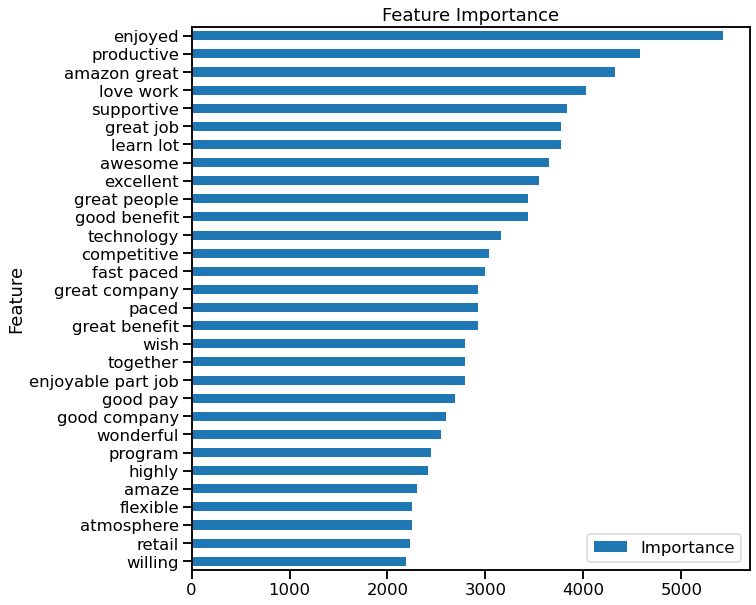

,Feature,Importance,Coefficient
388,willing,2189.233924,-7.691307
313,retail,2230.814815,-7.710122
24,atmosphere,2252.203260,-7.719664
129,flexible,2252.203260,-7.719664
10,amaze,2296.234604,-7.739026
168,highly,2414.232271,-7.789137
294,program,2439.302181,-7.799467
392,wonderful,2545.014085,-7.841891
145,good company,2601.382060,-7.863798
147,good pay,2690.776632,-7.897585


In [193]:
get_importance_logreg(mnb3, df_vec_count2_test, top_n=30)

> MNB model feature importance demonstrates the same tendency of relying on emotionally charged words. However, it puts more emphasis on words with positive connotations. And because words from neutral reviews overlap significantly with words from positive reviews, the model fails to identify neutral reviews correctly.

## Word frequency

In [194]:
series_tokens_test=pd.Series(token_reviews_test)

In [195]:
df_tokens_test=pd.DataFrame(series_tokens_test)
df_tokens_test

,0
0,opportunity whatever want learn job get advanc...
1,great place tell everyone love people work nec...
2,love work company good experience store well l...
3,low pay slave wage treat employee like trash w...
4,time provide opportunity lean branch coronary ...
...,...
30400,overall job nice would say labor pretty hard s...
30401,challenge able problem solve talented coworker...
30402,suite encourage growth advancement within lack...
30403,place good time slow good place enjoy work sea...


In [196]:
df_y_test=pd.DataFrame(y_test)
df_y_test=df_y_test.reset_index()
df_y_test=df_y_test.drop(['index'], axis=1)
df_y_test

,target
0,3
1,3
2,3
3,1
4,3
...,...
30400,3
30401,3
30402,3
30403,2


In [197]:
df_wordcloud_test=pd.merge(df_tokens_test, df_y_test, left_index=True, right_index=True)
df_wordcloud_test=df_wordcloud_test.rename(columns={0: "phrase"})
df_wordcloud_test

,phrase,target
0,opportunity whatever want learn job get advanc...,3
1,great place tell everyone love people work nec...,3
2,love work company good experience store well l...,3
3,low pay slave wage treat employee like trash w...,1
4,time provide opportunity lean branch coronary ...,3
...,...,...
30400,overall job nice would say labor pretty hard s...,3
30401,challenge able problem solve talented coworker...,3
30402,suite encourage growth advancement within lack...,3
30403,place good time slow good place enjoy work sea...,2


In [198]:
df_rating_negative_test=df_wordcloud_test.loc[df_wordcloud_test.target=='1']
df_rating_neutral_test=df_wordcloud_test.loc[df_wordcloud_test.target=='2']
df_rating_positive_test=df_wordcloud_test.loc[df_wordcloud_test.target=='3']
print(len(df_rating_negative_test), len(df_rating_neutral_test), len(df_rating_positive_test))

5899 6666 17840


In [199]:
df_rating_negative_test['phrase']

3        low pay slave wage treat employee like trash w...
6        job requirement change daily overwork new task...
11       would never go back worst job ive ever employe...
15       cold heartless unreasonable company ever work ...
19       manager duty hold gun point store ask step tho...
                               ...                        
30364    reward experience standpoint association resid...
30376    care employee child dont even bother apply mak...
30382    first job get barely recommend coworkers somew...
30390    much drama much hour provide corporate doesnt ...
30392                                             easy job
Name: phrase, Length: 5899, dtype: object

In [200]:
negative_words_test=[' '.join(df_rating_negative_test['phrase'])]
neutral_words_test=[' '.join(df_rating_neutral_test['phrase'])]
positive_words_test=[' '.join(df_rating_positive_test['phrase'])]

In [201]:
sw4=['work', 'job', 'amazon', 'company','good','great','place','also','really',
     'overall','would','get','lot', 'enjoyed','enjoy','love','however','make',
     'loved','even','done','still','like','come','well','though','give', 'u',
     'go','thing','really','one','take','want','make','could','say','ever',
     'alway','always','much','dont','way','year','[',']']
stopword_cloud_test_list=sw+sw2+sw3+sw4
stopword_cloud_test_set=set(stopword_cloud_test_list)

print(stopword_cloud_test_set)

{'done', 'place', 'didn', 'yourselves', 'índole', 'mightn', 'who', 'ـــ', 'm', "you'd", 'herself', 'ihs', 't', '晚上十点下班是正常的', 'medtronic', 'at', 'valley', 'king', 'but', 'even', 'renewable', 'being', 'like', 'great', 'here', 'shouldn', 'kbi', 'meadows', 'craft', 'once', 'give', 'make', 'university', 'more', 'áreas', 'apple', 'doing', 'have', "isn't", '⅞you', 'wouldn', 've', 'ética', 'am', 'hasn', 'other', 's', 'most', 'our', 'いい経験でした', "it's", '仕事は海軍の時の同じで', 'ámbito', "wasn't", 'can', 'nor', "haven't", 'until', 'as', 'go', 'él', 'splunk', 'had', 'his', 'wasn', 'against', 'frasier', 'ànd', 'really', 'weren', 'not', 'embassy', 'único', 'yours', 'invitae', 'my', 'again', ']', 'company', "won't", 'équipes', 'imagine', 'over', 'very', 'few', 'same', 'say', 'why', 'laboratory', 'much', 'enjoy', 'mustn', 'all', 'corporation', 'shan', 'ain', 'co', 'before', 'job', 'won', "that'll", 'świetnie', 'y', 'did', 'únicome', 'could', 'by', 'zayo', 'neta', 'équipe', 'how', 'i', 'she', 'because', 'still',

In [202]:
cloud_kws=dict(stopwords=stopword_cloud_test_set, width=1200, height=800, min_font_size=10, max_words=30,
               collocation_threshold = 5)

# Create a dictionary to generate all three clouds
wordcloud_dict={}
wordcloud_dict['Negative']= WordCloud(**cloud_kws,colormap='Reds', random_state=123).generate(str(negative_words_test))
wordcloud_dict['Positive']= WordCloud(**cloud_kws,colormap='Greens', random_state=123).generate(str(neutral_words_test))
wordcloud_dict['Neutral']= WordCloud(**cloud_kws,colormap='Greys', random_state=123).generate(str(positive_words_test))

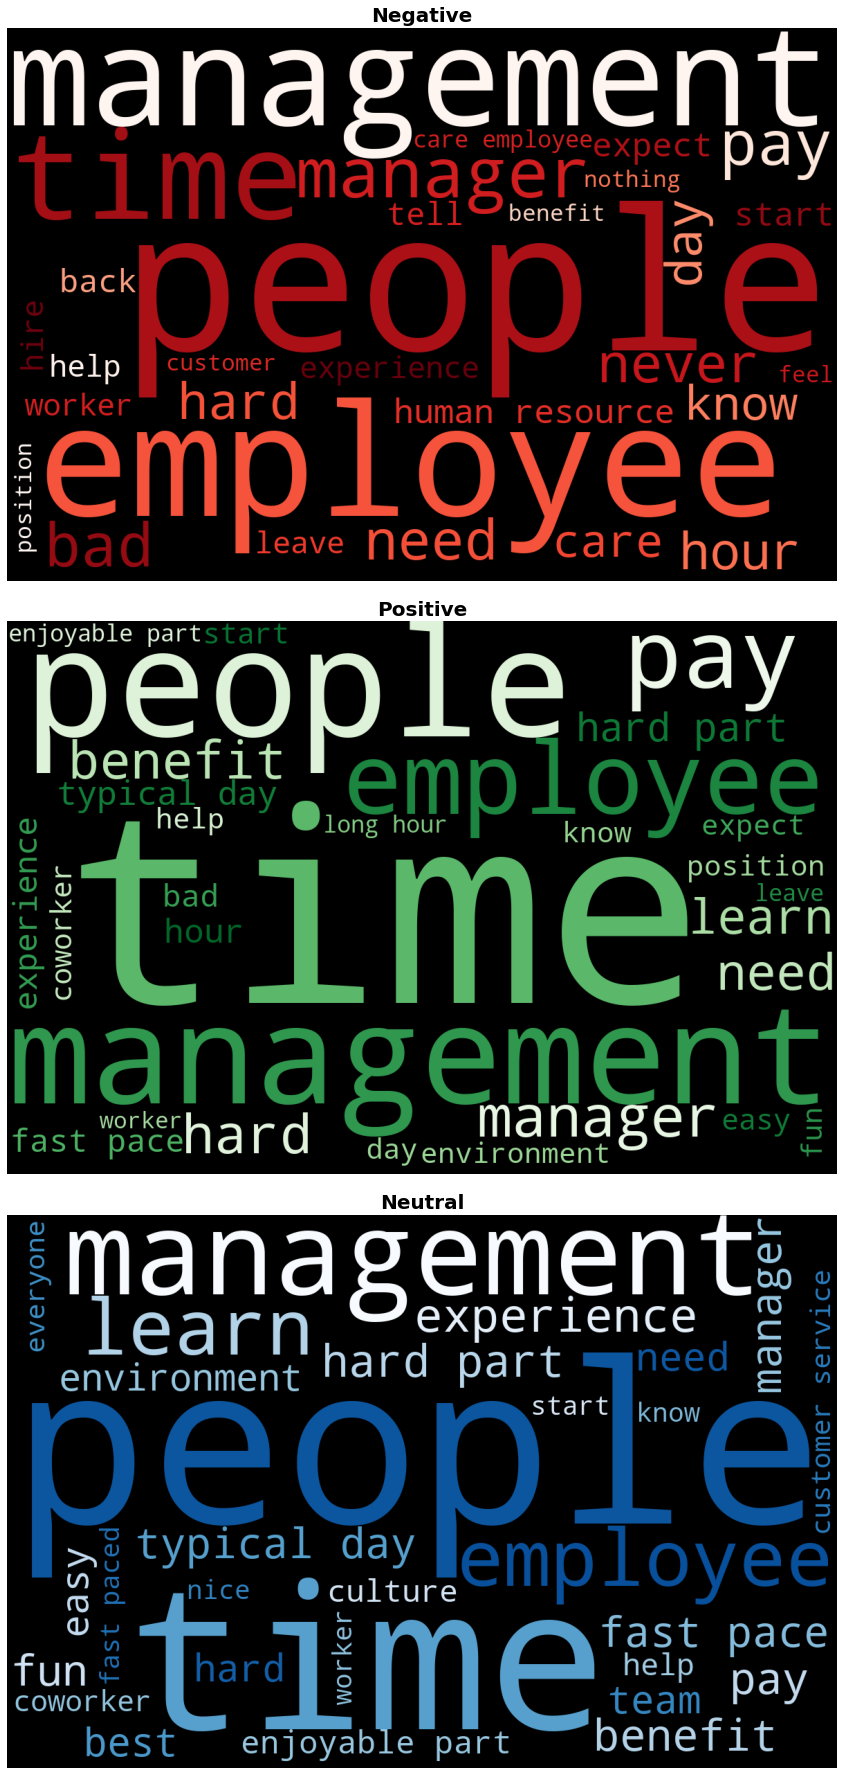

In [203]:
fig, ax=plt.subplots(nrows=3, figsize=(15,25))
title_font={'fontweight':'bold','fontsize':20}

i=0
for rating, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(rating, fontdict=title_font)
    ax[i].axis('off')
    i+=1

plt.tight_layout()
plt.show()

### Spotchecking the reviews

In [35]:
spot_check(df, retries=1)

Enter a word to check: time
Ratio of negative reviews with the word "time":0.244
Ration of positive reviews with the word "time":0.222
Ration of neutral reviews with the word "time":0.253



In [44]:
pull_out_sentences(df, ).style.set_properties(subset=['Review_Text'], **{'width-min': '1000px'})

Enter a review class to check (Negative/Positive/Neutral): Negative
Enter a word/a bigram to check: manager
Class Negative contains 3611 records with word manager


,Company,ReviewID,Rating,Review_Text
40854,Brookdale Senior Living,18fv8atja5n8gd0g,1,"I worked as a manager for this company, and stepped down from the position. In a Meeting one of the managers stated (Let's take the Residents pet cat down to the Chinese restaurant and cook it.) This was said in the presence of two of our Asian employees, and also the director who did nothing to stop this behavior. The employees are over worked, Under paid, Stressed out, and burned out. The management team with the exception of one is a joke ,The director is a total air head, and the foodservice manager is a buffoon."
8178,Amazon.com,1ecmb8c4np11p800,1,"Very unorganized, managers are very rude and have no clue what is going on. they will ask you to do things that they would never do themselves. if you finish early they make sweep the warehouse as busy work"
78610,Amazon.com,1ckg8kjnq1fdv2bf,1,"its a long work day with boring managers. sometimes its hot in there,the people there look sad or mad all the time, your work goes recognized. i feel underpaid ."


# Conclusions and recommendations

## Conclusions

<span style="font-size:1.5em;">This project had two goals:</span><br>
* Developing a predictive classification model of employer review rating
* Gaining insight into factors affecting satisfaction or dissatisfaction of people with their employer.<br><br>

<span style="font-size:1.5em;">The project results are:</span><br>

* Two models with relatively good predictive power were built. Both top models were better at predicting positive and negative reviews while predicting neutral reviews appears to be more difficult.<br>
* Understanding that the most influential factors affecting employees' opinions are a human factor (surrounding people, primarily management) and time.<br><br><br>
* * * 
<br>
<span style="font-size:1.5em;">The models:</span><br>

* The best performing models are Logistic Regression model and the Multinomial Naive Bayes model. Their performance F1-macro score metrics were 0.55 and 0.56, respectively. The baseline DummyClassifier model has the same metrics at 0.25. The improvement is very prominent.<br><br>
* Multinomial Naive Bayes model displayed better performance in identifying positive reviews, while the Logistic Regression model demonstrated a better ability to distinguish between all three classes.<br><br>
* Both of the models used reduced wordsets with 406. The reduced word set was used for two reasons: to reduce the overfitting of the models and to minimize computational time. Training an LRCV classifier with the full wordset of 46962 unique words overwhelmed the computational resources and generated an over-fitted model.

<br><br>

<span style="font-size:1.5em;">The Importance of Models' Predictors:</span>  <br><br>

* Both models identified powerfully emotionally charged words as the best predictors of a class a review belongs to. 
* Words
 1. horrible
 2. terrible
 3. poor
 
 
> are the three most influential predictors of a review belonging to a negative class.

* Words
 1. great
 2. awesome
 3. excellent 
 
> are the three most influential predictors of a review belonging to a positive class.

* That fact makes it challenging to identify neutral reviews correctly. Neutral reviews usually have both trends or none at all. If people don't experience intense emotions, they are less likely to use emotionally charged words.

    * An example of Neutral review with the word 'horrible':
    
    >Had a horrible experience working there. I got sick while working there, took a medical leave to take care of myself after working all through peak season, then got terminated because they are horrible with communication and resolving issues. Would never recommend anyone to work there.<br>
    
    * While the content of this review seems to be pretty negative, the reviewer rated it as a neutral one<br><bR>
    
    * An example of a Neutral review  with the word 'excellent':
        >IBM has been a great place for me to learn and grow. The job variety was awesome. This allowed me to make excellent contributions to every team to which I belonged. This opportunity still exists, but is usually in the low cost countries.
    * The content of this review is a positive one, but it has a negative part. It is not related to the company per se but more to a global tendency of shifting jobs overseas.<br><br>


* The fact that neutral class reviews are more difficult to identify might also be related to a psychological tendency of people to be polite unless they are agitated. The argument in favor of that theory is that both models misclassify neutral reviews as positive more frequently than misclassify them as negative.
    * The first model identified neutral reviews correctly only in 22.5% of all cases. It misclassified them as positive in 52% of all cases and as negative in 25.3%. 
    * The second model did a better job correctly identifying neutral reviews; it identified them correctly in 40.6% of all cases and misclassified them as positive in 31.2% of the cases and as negative in 28.2% of the cases.
<br><br>

<span style="font-size:1.5em;">The most influential factors affecting employees' opinion of a company:</span>  <br><br>
* The concept of "time" is broad. Based on the spot check analysis of reviews with the word "time" in the body of a review, it can be in the context of:
        1. a full-/part- time job
        2. time-off
        3. time-management
        4. employee's time with a company
        5. etc.


>It does not appear that word 'time' is more prevalent in any one class, but it does seem to be on people's minds frequently either positively or negatively.
    
![image benefit_freq](images/time.png)


* Words "manage," "management," and "manager" come up in negative reviews almost twice as frequently as in positive reviews. 

![image manager_freq](images/management.png)

* That implies that if a person has a negative opinion of an employer, it is most probably related to a bad relationship with their manager(s). Even the word "pay" is not as frequent in negative reviews as the words "manager"/"management/"manage" (combined) are.
 While the word "benefit" seemingly affects a negative opinion much less than one could expect, it is more frequent in positive reviews than in negative ones.

![image benefit_freq](images/benefit_pay.png)

______________________________________________________
<p></p><br>

<br>
<span style="font-size:1.5em;">Limitations of the model:</span><br><br>
    
> 1. The built models are relatively simple and might somewhat lack predictive power, therefore more complex, and ensemble models should be tried and tested.<br>
    
>    2. Computational resources are a limiting factor in building and testing more complex models. In such cases, Google Colab or Databricks cloud-based resources should be used. There are other alternatives of cloud resources as well that might be worth exploring.<br>
    
>    3. NLP Multiclass classification models could be necessary in some situations, but they perform worse than binary classification models.
______________________________________________________
<p></p>
<br><br>
<span style="font-size:1.5em;">Suggestion for future improvements:</span><br><br>
    
>    1. Convert the dataset to a binary classification dataset by removing the neutral reviews. <br>
    
>    2. Another possible strategy is to reduce the original dataset to the records with ratings 1 and 5 only. The argument in favor of that improvement is the most negative and the most positive reviews have the most value for companies; they allow to identify weaknesses and strengths more easily.<br>
    
>    3. Use unsupervised clustering techniques to assign classes to the full dataset rather than using rating label<br>

>  4. Explore Theme Extraction and Context Analysis models


## Recommendations


1. Test the models built in this project on their internal datasets of employees' open-ended survey answers to a question of their opinion on their group, department, or the company.
2. Make sure that your internal surveys are strictly anonymous and privacy-proof.
3. Implement an auto-alert system to identify negative reviews to address existing problems early.
4. Identification of positive reviews might be a great source of information about groups, departments, and the company's strengths.